In [1]:
# Environment Setup for ISAS Motion Classification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import joblib

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Signal Processing and Statistics
from scipy import stats
from scipy.signal import find_peaks, savgol_filter
from scipy.spatial.distance import euclidean
from collections import deque

# Check GPU and setup
print("=" * 50)
print("ISAS MOTION CLASSIFICATION SETUP")
print("=" * 50)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("\n✅ Environment setup complete!")

ISAS MOTION CLASSIFICATION SETUP
PyTorch version: 2.6.0+cu124
CUDA available: False
Using CPU
Using device: cpu

✅ Environment setup complete!


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up data paths
import os
data_path = '/content/drive/MyDrive/ISAS'
print(f"Data path: {data_path}")

# Check if path exists
if os.path.exists(data_path):
    print("✓ Data path exists")
    files = os.listdir(data_path)
    print(f"Found {len(files)} items in directory")
    print("First 10 items:", files[:10])
else:
    print("✗ Data path not found")

Mounted at /content/drive
Data path: /content/drive/MyDrive/ISAS
✓ Data path exists
Found 129 items in directory
First 10 items: ['requirements.txt', 'main.py', 'analyze_sitting_quietly.py', 'main2.py', 'main3.py', 'processed_frames_simple_log.csv', 'mismatched_frames_simple_analysis.csv', 'check', '.git', 'output']


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Setup data paths based on your structure
base_path = '/content/drive/MyDrive/ISAS'
train_data_path = os.path.join(base_path, 'Train_Data')

print(f"Base path: {base_path}")
print(f"Train data path: {train_data_path}")

# Check if paths exist
if os.path.exists(base_path):
    print("✅ Base path exists")
    items = os.listdir(base_path)
    print(f"Items in base directory: {items}")
else:
    print("❌ Base path not found!")

if os.path.exists(train_data_path):
    print("✅ Train data path exists")
    train_items = os.listdir(train_data_path)
    print(f"Items in Train_Data: {train_items}")

    # Check for keypointlabel directory
    keypointlabel_path = os.path.join(train_data_path, 'keypointlabel')
    if os.path.exists(keypointlabel_path):
        print("✅ keypointlabel directory found")
        csv_files = [f for f in os.listdir(keypointlabel_path) if f.endswith('.csv')]
        print(f"CSV files found: {csv_files}")
    else:
        print("❌ keypointlabel directory not found!")
else:
    print("❌ Train data path not found!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base path: /content/drive/MyDrive/ISAS
Train data path: /content/drive/MyDrive/ISAS/Train_Data
✅ Base path exists
Items in base directory: ['requirements.txt', 'main.py', 'analyze_sitting_quietly.py', 'main2.py', 'main3.py', 'processed_frames_simple_log.csv', 'mismatched_frames_simple_analysis.csv', 'check', '.git', 'output', 'Train_Data', '.notebook', '.cursor', 'outputs', 'test data_keypoint.csv', 'test_data_keypoint_labeled_attention_enhanced.csv', 'best_stgcn_model_fixed.pth', 'test_data_stgcn_comparison.csv', 'test_data_hierarchical_stgcn.csv', 'action_distribution_comparison.png', 'centered_skeleton_enhanced_throwing_analysis.mp4', 'centered_skeleton_hierarchical_stgcn.mp4', 'centered_skeleton_keypoint_labeled_attention_enhanced.mp4', 'centered_skeleton_stgcn_comparison.mp4', 'video_training', 'video_training_centered', 'test_data_enhanced_throwing_anal

In [4]:
# Enhanced Data Loading Functions
def load_isas_keypointlabel_data(train_data_path):
    """Load ISAS keypoint labeled data with comprehensive analysis"""
    keypointlabel_path = os.path.join(train_data_path, 'keypointlabel')

    if not os.path.exists(keypointlabel_path):
        print(f"❌ Keypointlabel path not found: {keypointlabel_path}")
        return None, []

    # Find all CSV files
    csv_files = [f for f in os.listdir(keypointlabel_path) if f.endswith('.csv')]
    print(f"Found {len(csv_files)} CSV files: {csv_files}")

    all_dataframes = []
    subject_info = []

    for csv_file in csv_files:
        file_path = os.path.join(keypointlabel_path, csv_file)
        print(f"\nLoading: {csv_file}")

        try:
            # Load CSV
            df = pd.read_csv(file_path)
            print(f"  Shape: {df.shape}")

            # Extract subject ID from filename
            if 'keypoints_with_labels_' in csv_file:
                subject_id = csv_file.replace('keypoints_with_labels_', '').replace('.csv', '')
            else:
                subject_id = csv_file.replace('.csv', '')

            # Add metadata
            df['subject_id'] = subject_id
            df['file_name'] = csv_file
            df['original_index'] = df.index

            # Check for Action Label column
            if 'Action Label' in df.columns:
                unique_actions = df['Action Label'].unique()
                print(f"  Unique actions: {len(unique_actions)}")
                print(f"  Actions: {list(unique_actions)}")

                # Count per action
                action_counts = df['Action Label'].value_counts()
                print(f"  Action distribution:")
                for action, count in action_counts.head().items():
                    print(f"    {action}: {count}")

            all_dataframes.append(df)
            subject_info.append({
                'subject_id': subject_id,
                'file_name': csv_file,
                'shape': df.shape,
                'actions': df['Action Label'].unique() if 'Action Label' in df.columns else []
            })

        except Exception as e:
            print(f"  ❌ Error loading {csv_file}: {e}")

    if all_dataframes:
        # Combine all dataframes
        combined_df = pd.concat(all_dataframes, ignore_index=True)
        print(f"\n✅ Successfully combined {len(all_dataframes)} files")
        print(f"Combined shape: {combined_df.shape}")

        return combined_df, subject_info
    else:
        print("❌ No data loaded")
        return None, []

# Load the data
print("Loading ISAS keypointlabel data...")
data, subject_info = load_isas_keypointlabel_data(train_data_path)

if data is not None:
    print(f"\n{'='*50}")
    print("DATAFRAME STRUCTURE ANALYSIS")
    print(f"{'='*50}")
    print(f"Total shape: {data.shape}")
    print(f"Columns: {len(data.columns)}")
    print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # Show column types
    print(f"\nColumn types:")
    print(data.dtypes.value_counts())

    # Show first few columns
    print(f"\nFirst 10 columns: {list(data.columns[:10])}")
    print(f"Last 5 columns: {list(data.columns[-5:])}")

    print(f"\nSubject distribution:")
    print(data['subject_id'].value_counts())

Loading ISAS keypointlabel data...
Found 5 CSV files: ['keypoints_with_labels_2.csv', 'keypoints_with_labels_1.csv', 'keypoints_with_labels_3.csv', 'keypoints_with_labels_4.csv', 'keypoints_with_labels_5.csv']

Loading: keypoints_with_labels_2.csv
  Shape: (74638, 36)
  Unique actions: 9
  Actions: ['Walking', 'Head banging', nan, 'Sitting quietly', 'Biting', 'Using phone', 'Throwing things', 'Eating snacks', 'Attacking']
  Action distribution:
    Sitting quietly: 14700
    Eating snacks: 14670
    Walking: 14460
    Using phone: 10980
    Attacking: 5760

Loading: keypoints_with_labels_1.csv
  Shape: (76456, 36)
  Unique actions: 9
  Actions: ['Walking', nan, 'Head banging', 'Sitting quietly', 'Biting', 'Using phone', 'Throwing things', 'Eating snacks', 'Attacking']
  Action distribution:
    Eating snacks: 14730
    Walking: 14610
    Sitting quietly: 14310
    Using phone: 10980
    Biting: 5610

Loading: keypoints_with_labels_3.csv
  Shape: (118087, 36)
  Unique actions: 9
  Actio

DETAILED DATAFRAME ANALYSIS
Keypoint columns found: 17 keypoints
Expected: 17 keypoints

Action column: 'Action Label'
Unique actions (9): ['Walking', 'Head banging', 'Sitting quietly', 'Biting', 'Using phone', 'Throwing things', 'Eating snacks', 'Attacking', 'Throwing']

Action distribution:
  Sitting quietly: 95,370 (20.6%)
  Walking: 83,670 (18.1%)
  Using phone: 79,710 (17.2%)
  Eating snacks: 73,080 (15.8%)
  Biting: 31,410 (6.8%)
  Attacking: 24,450 (5.3%)
  Head banging: 23,760 (5.1%)
  Throwing things: 17,700 (3.8%)
  Throwing: 2,280 (0.5%)
  NaN values: 31,653 (6.8%)

CLEANING DATASET
After removing NaN actions: 431430 rows (93.2%)
  Subject 2: kept 70138/74638 frames
  Subject 1: kept 71723/76456 frames
  Subject 3: kept 105210/118087 frames
  Subject 4: kept 106571/117921 frames
  Subject 5: kept 70768/75981 frames
Subject-wise cleaning: 424410 rows (91.6%)

Analyzing windows with cleaned data...

WINDOW ANALYSIS (size=150)

Subject 2: 71250 frames
  Number of complete windo

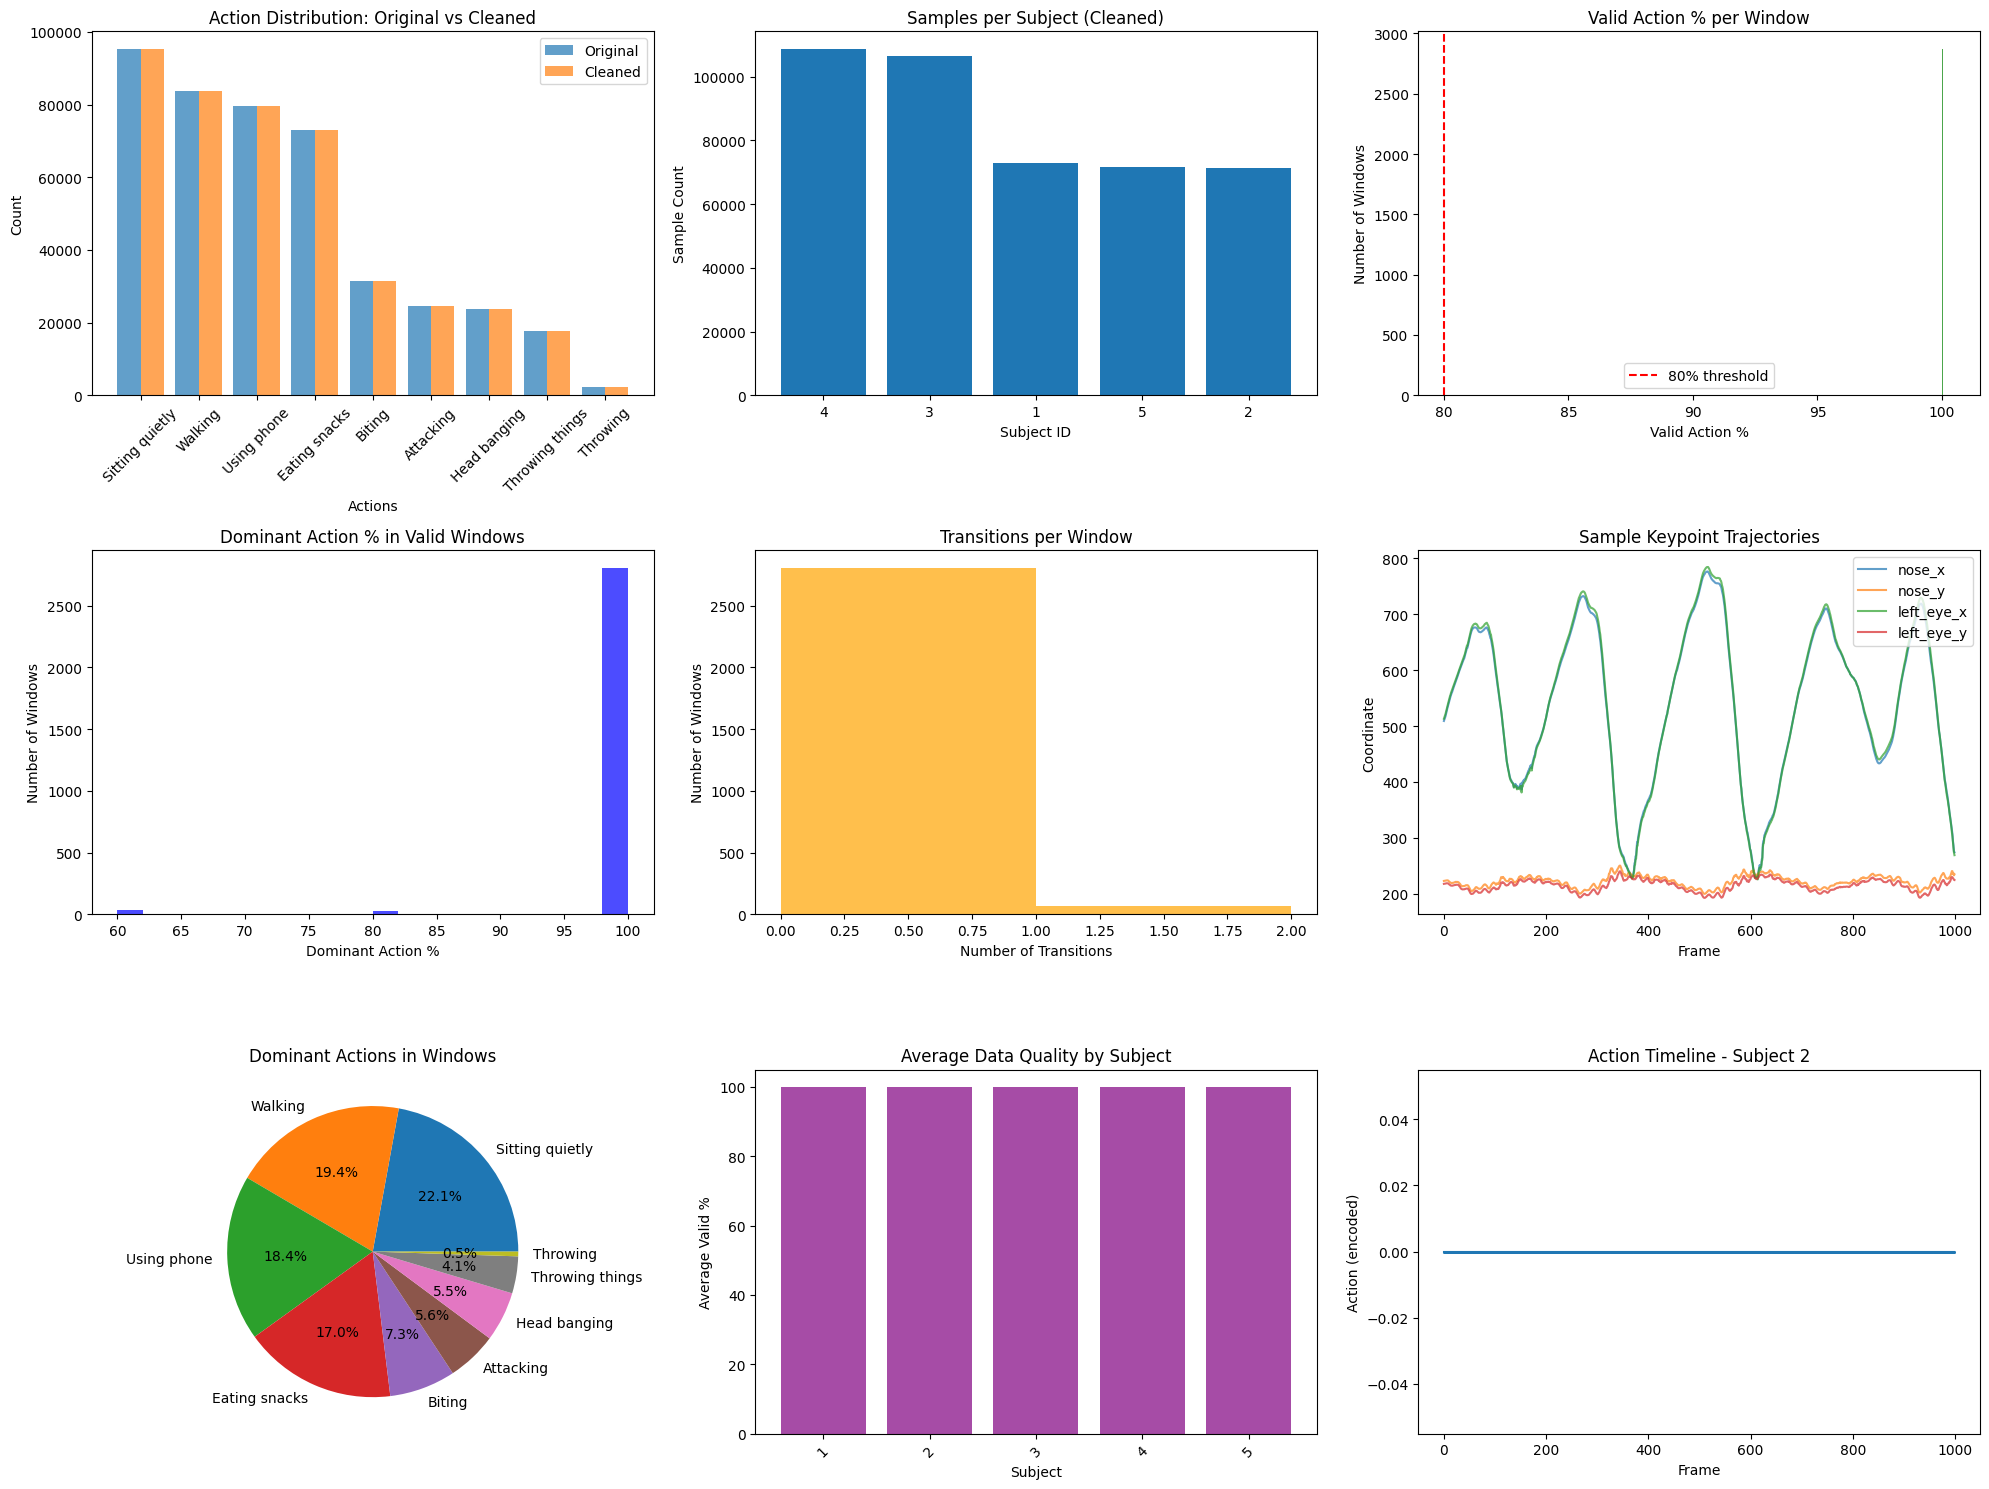


DATA ANALYSIS COMPLETE
Original data: 463,083 samples
Cleaned data: 431,430 samples
Windows analyzed: 2,874
Valid windows: 2,874

✅ Ready for feature extraction with 431,430 samples


In [5]:
# Comprehensive EDA with Window Size Analysis - FIXED VERSION
KEYPOINT_NAMES = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
    'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
]

def analyze_dataframe_structure(df):
    """Analyze the structure of the dataframe in detail"""
    print("DETAILED DATAFRAME ANALYSIS")
    print("="*50)

    # Identify keypoint columns
    keypoint_cols = []
    for kp in KEYPOINT_NAMES:
        x_col = f"{kp}_x"
        y_col = f"{kp}_y"
        if x_col in df.columns and y_col in df.columns:
            keypoint_cols.extend([x_col, y_col])

    print(f"Keypoint columns found: {len(keypoint_cols)//2} keypoints")
    print(f"Expected: {len(KEYPOINT_NAMES)} keypoints")

    # Check for action label
    action_col = None
    for col in ['Action Label', 'action', 'label', 'class']:
        if col in df.columns:
            action_col = col
            break

    if action_col:
        print(f"\nAction column: '{action_col}'")

        # Remove NaN values for analysis
        valid_actions = df[action_col].dropna()
        unique_actions = valid_actions.unique()
        print(f"Unique actions ({len(unique_actions)}): {list(unique_actions)}")

        # Action distribution (excluding NaN)
        action_counts = valid_actions.value_counts()
        print(f"\nAction distribution:")
        for action, count in action_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {action}: {count:,} ({percentage:.1f}%)")

        # NaN count
        nan_count = df[action_col].isna().sum()
        if nan_count > 0:
            nan_pct = (nan_count / len(df)) * 100
            print(f"  NaN values: {nan_count:,} ({nan_pct:.1f}%)")

    return keypoint_cols, action_col, unique_actions if action_col else []

def analyze_window_patterns(df, action_col, window_size=150):
    """Analyze patterns in windows of specified size - FIXED VERSION"""
    print(f"\nWINDOW ANALYSIS (size={window_size})")
    print("="*50)

    window_analysis = []

    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject].reset_index(drop=True)
        print(f"\nSubject {subject}: {len(subject_data)} frames")

        # Create windows
        num_windows = len(subject_data) // window_size
        print(f"  Number of complete windows: {num_windows}")

        for w in range(num_windows):
            start_idx = w * window_size
            end_idx = start_idx + window_size
            window_data = subject_data.iloc[start_idx:end_idx]

            # Analyze window
            if action_col in window_data.columns:
                # Remove NaN values for this window
                window_actions_valid = window_data[action_col].dropna()

                if len(window_actions_valid) > 0:
                    # Get action counts
                    window_actions = window_actions_valid.value_counts()
                    dominant_action = window_actions.index[0]
                    dominant_count = window_actions.iloc[0]
                    dominant_pct = (dominant_count / len(window_data)) * 100

                    # Check for transitions
                    transitions = []
                    if len(window_actions_valid) > 1:
                        prev_action = None
                        for i, current_action in enumerate(window_data[action_col]):
                            if pd.notna(current_action):
                                if prev_action is not None and current_action != prev_action:
                                    transitions.append((prev_action, current_action, i))
                                prev_action = current_action

                    # Calculate valid action percentage
                    valid_action_pct = (len(window_actions_valid) / len(window_data)) * 100

                    window_analysis.append({
                        'subject': subject,
                        'window': w,
                        'start_frame': start_idx,
                        'end_frame': end_idx,
                        'dominant_action': dominant_action,
                        'dominant_pct': dominant_pct,
                        'dominant_count': dominant_count,
                        'valid_frames': len(window_actions_valid),
                        'valid_pct': valid_action_pct,
                        'num_transitions': len(transitions),
                        'unique_actions': len(window_actions),
                        'actions_in_window': list(window_actions.index),
                        'nan_count': window_data[action_col].isna().sum()
                    })
                else:
                    # Window with no valid actions
                    window_analysis.append({
                        'subject': subject,
                        'window': w,
                        'start_frame': start_idx,
                        'end_frame': end_idx,
                        'dominant_action': 'NO_VALID_ACTION',
                        'dominant_pct': 0.0,
                        'dominant_count': 0,
                        'valid_frames': 0,
                        'valid_pct': 0.0,
                        'num_transitions': 0,
                        'unique_actions': 0,
                        'actions_in_window': [],
                        'nan_count': len(window_data)
                    })

    window_df = pd.DataFrame(window_analysis)

    if len(window_df) > 0:
        print(f"\nTotal windows analyzed: {len(window_df)}")

        # Filter out windows with no valid actions for statistics
        valid_windows = window_df[window_df['valid_frames'] > 0]

        if len(valid_windows) > 0:
            print(f"Windows with valid actions: {len(valid_windows)}")
            print(f"Average dominant action %: {valid_windows['dominant_pct'].mean():.1f}%")
            print(f"Average valid frames per window: {valid_windows['valid_frames'].mean():.1f}")
            print(f"Average transitions per window: {valid_windows['num_transitions'].mean():.1f}")

            # Most common dominant actions
            print(f"\nMost common dominant actions in windows:")
            dominant_actions = valid_windows['dominant_action'].value_counts()
            for action, count in dominant_actions.head().items():
                print(f"  {action}: {count} windows")

        # Windows with issues
        invalid_windows = window_df[window_df['valid_frames'] == 0]
        if len(invalid_windows) > 0:
            print(f"\n⚠️  Windows with no valid actions: {len(invalid_windows)}")

    return window_df

def create_clean_dataset(df, action_col, min_valid_pct=0.8):
    """Create a cleaned dataset by removing rows with too many NaN actions"""
    print(f"\nCLEANING DATASET")
    print("="*30)

    original_size = len(df)

    # Option 1: Remove rows where action is NaN
    df_clean = df.dropna(subset=[action_col]).copy()
    print(f"After removing NaN actions: {len(df_clean)} rows ({len(df_clean)/original_size*100:.1f}%)")

    # Option 2: For each subject, keep only portions with sufficient valid data
    df_subject_clean = []

    for subject in df['subject_id'].unique():
        subject_data = df[df['subject_id'] == subject].copy()

        # Calculate rolling valid percentage
        window_size = 150
        subject_data['valid_action'] = subject_data[action_col].notna()

        if len(subject_data) >= window_size:
            # Calculate rolling mean of valid actions
            rolling_valid = subject_data['valid_action'].rolling(
                window=window_size, center=True, min_periods=window_size//2
            ).mean()

            # Keep only portions where valid percentage is above threshold
            mask = rolling_valid >= min_valid_pct
            clean_portion = subject_data[mask].copy()

            if len(clean_portion) > 0:
                df_subject_clean.append(clean_portion)
                print(f"  Subject {subject}: kept {len(clean_portion)}/{len(subject_data)} frames")

    if df_subject_clean:
        df_subject_clean = pd.concat(df_subject_clean, ignore_index=True)
        print(f"Subject-wise cleaning: {len(df_subject_clean)} rows ({len(df_subject_clean)/original_size*100:.1f}%)")
    else:
        df_subject_clean = df_clean

    return df_clean, df_subject_clean

# Perform comprehensive analysis
if data is not None:
    keypoint_cols, action_col, unique_actions = analyze_dataframe_structure(data)

    # Clean the dataset
    data_clean, data_subject_clean = create_clean_dataset(data, action_col)

    # Window analysis with cleaned data
    print(f"\nAnalyzing windows with cleaned data...")
    window_df = analyze_window_patterns(data_clean, action_col, window_size=150)

    # Visualization
    plt.figure(figsize=(20, 15))

    # Plot 1: Action distribution (original vs cleaned)
    plt.subplot(3, 3, 1)
    if action_col:
        original_counts = data[action_col].value_counts()
        clean_counts = data_clean[action_col].value_counts()

        x_pos = range(len(clean_counts))
        plt.bar([x - 0.2 for x in x_pos], [original_counts.get(action, 0) for action in clean_counts.index],
                width=0.4, label='Original', alpha=0.7)
        plt.bar([x + 0.2 for x in x_pos], clean_counts.values,
                width=0.4, label='Cleaned', alpha=0.7)

        plt.title('Action Distribution: Original vs Cleaned')
        plt.xlabel('Actions')
        plt.ylabel('Count')
        plt.xticks(x_pos, clean_counts.index, rotation=45)
        plt.legend()

    # Plot 2: Subject distribution
    plt.subplot(3, 3, 2)
    subject_counts = data_clean['subject_id'].value_counts()
    plt.bar(subject_counts.index, subject_counts.values)
    plt.title('Samples per Subject (Cleaned)')
    plt.xlabel('Subject ID')
    plt.ylabel('Sample Count')

    # Plot 3: Window validity
    plt.subplot(3, 3, 3)
    if len(window_df) > 0:
        plt.hist(window_df['valid_pct'], bins=20, alpha=0.7, color='green')
        plt.title('Valid Action % per Window')
        plt.xlabel('Valid Action %')
        plt.ylabel('Number of Windows')
        plt.axvline(x=80, color='red', linestyle='--', label='80% threshold')
        plt.legend()

    # Plot 4: Dominant action percentages
    plt.subplot(3, 3, 4)
    if len(window_df) > 0:
        valid_windows = window_df[window_df['valid_frames'] > 0]
        if len(valid_windows) > 0:
            plt.hist(valid_windows['dominant_pct'], bins=20, alpha=0.7, color='blue')
            plt.title('Dominant Action % in Valid Windows')
            plt.xlabel('Dominant Action %')
            plt.ylabel('Number of Windows')

    # Plot 5: Transitions per window
    plt.subplot(3, 3, 5)
    if len(window_df) > 0:
        valid_windows = window_df[window_df['valid_frames'] > 0]
        if len(valid_windows) > 0:
            max_transitions = valid_windows['num_transitions'].max()
            bins = range(0, max_transitions + 2)
            plt.hist(valid_windows['num_transitions'], bins=bins, alpha=0.7, color='orange')
            plt.title('Transitions per Window')
            plt.xlabel('Number of Transitions')
            plt.ylabel('Number of Windows')

    # Plot 6: Sample keypoint trajectories
    plt.subplot(3, 3, 6)
    if len(keypoint_cols) > 0:
        sample_data = data_clean[keypoint_cols[:4]].head(1000)
        for col in sample_data.columns:
            plt.plot(sample_data.index, sample_data[col], alpha=0.7, label=col[:15])
        plt.title('Sample Keypoint Trajectories')
        plt.xlabel('Frame')
        plt.ylabel('Coordinate')
        plt.legend()

    # Plot 7: Window dominant actions
    plt.subplot(3, 3, 7)
    if len(window_df) > 0:
        valid_windows = window_df[window_df['valid_frames'] > 0]
        if len(valid_windows) > 0:
            action_counts = valid_windows['dominant_action'].value_counts()
            plt.pie(action_counts.values, labels=action_counts.index, autopct='%1.1f%%')
            plt.title('Dominant Actions in Windows')

    # Plot 8: Data quality by subject
    plt.subplot(3, 3, 8)
    if len(window_df) > 0:
        subject_quality = window_df.groupby('subject')['valid_pct'].mean()
        plt.bar(subject_quality.index, subject_quality.values, color='purple', alpha=0.7)
        plt.title('Average Data Quality by Subject')
        plt.xlabel('Subject')
        plt.ylabel('Average Valid %')
        plt.xticks(rotation=45)

    # Plot 9: Timeline view
    plt.subplot(3, 3, 9)
    if action_col in data_clean.columns:
        # Show action timeline for first subject
        first_subject = data_clean['subject_id'].iloc[0]
        subject_sample = data_clean[data_clean['subject_id'] == first_subject].head(1000)

        # Create numeric mapping for actions
        action_mapping = {action: i for i, action in enumerate(subject_sample[action_col].unique())}
        numeric_actions = subject_sample[action_col].map(action_mapping)

        plt.plot(subject_sample.index, numeric_actions, marker='o', markersize=1)
        plt.title(f'Action Timeline - Subject {first_subject}')
        plt.xlabel('Frame')
        plt.ylabel('Action (encoded)')

    plt.tight_layout()
    plt.show()

    print(f"\n{'='*50}")
    print("DATA ANALYSIS COMPLETE")
    print(f"{'='*50}")
    print(f"Original data: {len(data):,} samples")
    print(f"Cleaned data: {len(data_clean):,} samples")
    print(f"Windows analyzed: {len(window_df):,}")
    print(f"Valid windows: {len(window_df[window_df['valid_frames'] > 0]):,}")

    # Store cleaned data for next steps
    final_data = data_clean
    print(f"\n✅ Ready for feature extraction with {len(final_data):,} samples")

In [ ]:
# Window-based Feature Extraction for ISAS Motion Classification
import scipy.stats as stats
from scipy.signal import find_peaks, savgol_filter
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import time

class ISASWindowFeatureExtractor:
    def __init__(self, window_size=150):
        self.window_size = window_size
        self.keypoint_names = KEYPOINT_NAMES
        self.scaler = StandardScaler()

        # Define 8 main motion classes (excluding 'Throwing' due to low samples)
        self.motion_classes = {
            'Sitting quietly': 0,
            'Walking': 1,
            'Using phone': 2,
            'Eating snacks': 3,
            'Biting': 4,
            'Attacking': 5,
            'Head banging': 6,
            'Throwing things': 7
        }

        print(f"✅ Initialized Window Feature Extractor")
        print(f"   Window size: {self.window_size}")
        print(f"   Target classes: {len(self.motion_classes)}")
        print(f"   Class mapping: {self.motion_classes}")

    def get_keypoint_columns(self, df):
        """Get all keypoint coordinate columns"""
        keypoint_cols = []
        for kp_name in self.keypoint_names:
            x_col = f"{kp_name}_x"
            y_col = f"{kp_name}_y"
            if x_col in df.columns and y_col in df.columns:
                keypoint_cols.extend([x_col, y_col])
        return keypoint_cols

    def extract_bounding_box_features(self, window_data):
        """Extract comprehensive bounding box features from window"""
        features = {}

        # Get all keypoint coordinates
        keypoint_cols = self.get_keypoint_columns(window_data)
        x_cols = [col for col in keypoint_cols if col.endswith('_x')]
        y_cols = [col for col in keypoint_cols if col.endswith('_y')]

        if not x_cols or not y_cols:
            return features

        # Calculate frame-by-frame bounding boxes
        bbox_metrics = []
        center_positions = []

        for idx, row in window_data.iterrows():
            # Get valid coordinates for this frame
            valid_x = [row[col] for col in x_cols if pd.notna(row[col])]
            valid_y = [row[col] for col in y_cols if pd.notna(row[col])]

            if len(valid_x) > 0 and len(valid_y) > 0:
                min_x, max_x = min(valid_x), max(valid_x)
                min_y, max_y = min(valid_y), max(valid_y)

                width = max_x - min_x
                height = max_y - min_y
                area = width * height
                aspect_ratio = height / (width + 1e-8)
                center_x = (min_x + max_x) / 2
                center_y = (min_y + max_y) / 2

                bbox_metrics.append({
                    'width': width, 'height': height, 'area': area,
                    'aspect_ratio': aspect_ratio, 'perimeter': 2*(width + height)
                })
                center_positions.append((center_x, center_y))

        if bbox_metrics:
            # Statistical features for each metric
            for metric in ['width', 'height', 'area', 'aspect_ratio', 'perimeter']:
                values = [bm[metric] for bm in bbox_metrics]
                features[f'bbox_{metric}_mean'] = np.mean(values)
                features[f'bbox_{metric}_std'] = np.std(values)
                features[f'bbox_{metric}_min'] = np.min(values)
                features[f'bbox_{metric}_max'] = np.max(values)
                features[f'bbox_{metric}_range'] = np.max(values) - np.min(values)
                features[f'bbox_{metric}_cv'] = np.std(values) / (np.mean(values) + 1e-8)

                if len(values) > 1:
                    # Temporal derivatives
                    diff1 = np.diff(values)
                    features[f'bbox_{metric}_velocity_mean'] = np.mean(diff1)
                    features[f'bbox_{metric}_velocity_std'] = np.std(diff1)

                    if len(diff1) > 1:
                        diff2 = np.diff(diff1)
                        features[f'bbox_{metric}_accel_mean'] = np.mean(diff2)
                        features[f'bbox_{metric}_accel_std'] = np.std(diff2)

            # Center movement analysis
            if len(center_positions) > 1:
                # Calculate displacement sequence
                displacements = []
                for i in range(1, len(center_positions)):
                    disp = euclidean(center_positions[i-1], center_positions[i])
                    displacements.append(disp)

                features['bbox_total_displacement'] = sum(displacements)
                features['bbox_avg_displacement'] = np.mean(displacements)
                features['bbox_max_displacement'] = np.max(displacements)
                features['bbox_displacement_std'] = np.std(displacements)

                # Path smoothness
                if len(displacements) > 2:
                    displacement_changes = np.diff(displacements)
                    features['bbox_path_smoothness'] = -np.mean(np.abs(displacement_changes))

        return features

    def extract_motion_features(self, window_data):
        """Extract motion-based features"""
        features = {}

        keypoint_cols = self.get_keypoint_columns(window_data)

        # Calculate velocities for each keypoint
        all_velocities = []
        keypoint_motion = {}

        for kp_name in self.keypoint_names:
            x_col = f"{kp_name}_x"
            y_col = f"{kp_name}_y"

            if x_col in window_data.columns and y_col in window_data.columns:
                x_data = window_data[x_col].dropna()
                y_data = window_data[y_col].dropna()

                if len(x_data) > 1 and len(y_data) > 1:
                    # Calculate velocities
                    x_vel = np.diff(x_data.values)
                    y_vel = np.diff(y_data.values)

                    # Velocity magnitudes
                    vel_magnitudes = np.sqrt(x_vel**2 + y_vel**2)

                    if len(vel_magnitudes) > 0:
                        keypoint_motion[kp_name] = vel_magnitudes
                        all_velocities.extend(vel_magnitudes)

                        # Per-keypoint features
                        features[f'motion_{kp_name}_mean'] = np.mean(vel_magnitudes)
                        features[f'motion_{kp_name}_std'] = np.std(vel_magnitudes)
                        features[f'motion_{kp_name}_max'] = np.max(vel_magnitudes)

                        # Motion consistency
                        if len(vel_magnitudes) > 2:
                            autocorr = np.corrcoef(vel_magnitudes[:-1], vel_magnitudes[1:])[0,1]
                            features[f'motion_{kp_name}_consistency'] = autocorr if not np.isnan(autocorr) else 0

        # Overall motion features
        if all_velocities:
            features['motion_overall_mean'] = np.mean(all_velocities)
            features['motion_overall_std'] = np.std(all_velocities)
            features['motion_overall_max'] = np.max(all_velocities)
            features['motion_overall_energy'] = np.sum(np.array(all_velocities)**2)
            features['motion_overall_rms'] = np.sqrt(np.mean(np.array(all_velocities)**2))

            # Motion patterns
            if len(all_velocities) > 10:
                # Frequency analysis
                fft_vals = np.fft.fft(all_velocities[:len(all_velocities)//2*2])  # Ensure even length
                power_spectrum = np.abs(fft_vals)**2
                freqs = np.fft.fftfreq(len(fft_vals))

                # Dominant frequency
                positive_freqs = freqs[:len(freqs)//2]
                positive_power = power_spectrum[:len(power_spectrum)//2]

                if len(positive_power) > 1:
                    dominant_idx = np.argmax(positive_power[1:]) + 1
                    features['motion_dominant_freq'] = positive_freqs[dominant_idx]
                    features['motion_spectral_energy'] = np.sum(positive_power)

                # Rhythmicity (periodicity detection)
                autocorr_full = np.correlate(all_velocities, all_velocities, mode='full')
                autocorr_half = autocorr_full[len(autocorr_full)//2:]
                if len(autocorr_half) > 10:
                    peaks, _ = find_peaks(autocorr_half[1:11])  # Look for peaks in first 10 lags
                    features['motion_rhythmicity'] = len(peaks)

        return features

    def extract_distance_features(self, window_data):
        """Extract distance-based features"""
        features = {}

        # Key body part distances
        distance_pairs = [
            ('left_wrist', 'right_wrist', 'hand_span'),
            ('left_shoulder', 'right_shoulder', 'shoulder_width'),
            ('left_hip', 'right_hip', 'hip_width'),
            ('left_ankle', 'right_ankle', 'ankle_span'),
            ('nose', 'left_hip', 'head_body_left'),
            ('nose', 'right_hip', 'head_body_right'),
            ('left_wrist', 'left_ankle', 'left_limb_span'),
            ('right_wrist', 'right_ankle', 'right_limb_span'),
            ('left_shoulder', 'left_hip', 'left_torso'),
            ('right_shoulder', 'right_hip', 'right_torso')
        ]

        for kp1, kp2, dist_name in distance_pairs:
            x1_col, y1_col = f"{kp1}_x", f"{kp1}_y"
            x2_col, y2_col = f"{kp2}_x", f"{kp2}_y"

            if all(col in window_data.columns for col in [x1_col, y1_col, x2_col, y2_col]):
                distances = []

                for idx, row in window_data.iterrows():
                    if all(pd.notna(row[col]) for col in [x1_col, y1_col, x2_col, y2_col]):
                        dist = euclidean([row[x1_col], row[y1_col]], [row[x2_col], row[y2_col]])
                        distances.append(dist)

                if distances:
                    # Statistical features
                    features[f'dist_{dist_name}_mean'] = np.mean(distances)
                    features[f'dist_{dist_name}_std'] = np.std(distances)
                    features[f'dist_{dist_name}_min'] = np.min(distances)
                    features[f'dist_{dist_name}_max'] = np.max(distances)
                    features[f'dist_{dist_name}_range'] = np.max(distances) - np.min(distances)
                    features[f'dist_{dist_name}_cv'] = np.std(distances) / (np.mean(distances) + 1e-8)

                    # Stability and change
                    if len(distances) > 1:
                        changes = np.diff(distances)
                        features[f'dist_{dist_name}_stability'] = -np.std(changes)  # Negative std = more stable
                        features[f'dist_{dist_name}_change_rate'] = np.mean(np.abs(changes))

        return features

    def extract_pose_features(self, window_data):
        """Extract pose-specific features"""
        features = {}

        # Body part positions relative to center
        center_x_cols = [f"{kp}_x" for kp in ['left_hip', 'right_hip'] if f"{kp}_x" in window_data.columns]
        center_y_cols = [f"{kp}_y" for kp in ['left_hip', 'right_hip'] if f"{kp}_y" in window_data.columns]

        if center_x_cols and center_y_cols:
            # Calculate body center for each frame
            body_centers = []
            for idx, row in window_data.iterrows():
                valid_x = [row[col] for col in center_x_cols if pd.notna(row[col])]
                valid_y = [row[col] for col in center_y_cols if pd.notna(row[col])]

                if valid_x and valid_y:
                    center_x = np.mean(valid_x)
                    center_y = np.mean(valid_y)
                    body_centers.append((center_x, center_y))

            # Analyze relative positions
            extremity_keypoints = ['left_wrist', 'right_wrist', 'left_ankle', 'right_ankle', 'nose']

            for kp in extremity_keypoints:
                x_col, y_col = f"{kp}_x", f"{kp}_y"
                if x_col in window_data.columns and y_col in window_data.columns:
                    relative_distances = []

                    for i, (idx, row) in enumerate(window_data.iterrows()):
                        if i < len(body_centers) and pd.notna(row[x_col]) and pd.notna(row[y_col]):
                            rel_dist = euclidean([row[x_col], row[y_col]], body_centers[i])
                            relative_distances.append(rel_dist)

                    if relative_distances:
                        features[f'pose_{kp}_relative_dist_mean'] = np.mean(relative_distances)
                        features[f'pose_{kp}_relative_dist_std'] = np.std(relative_distances)

        # Angle features (simplified)
        # Calculate angle between key body segments
        angle_triplets = [
            ('left_shoulder', 'left_elbow', 'left_wrist', 'left_arm_angle'),
            ('right_shoulder', 'right_elbow', 'right_wrist', 'right_arm_angle'),
            ('left_hip', 'left_knee', 'left_ankle', 'left_leg_angle'),
            ('right_hip', 'right_knee', 'right_ankle', 'right_leg_angle')
        ]

        for kp1, kp2, kp3, angle_name in angle_triplets:
            cols = [(f"{kp}_x", f"{kp}_y") for kp in [kp1, kp2, kp3]]

            if all(col[0] in window_data.columns and col[1] in window_data.columns for col in cols):
                angles = []

                for idx, row in window_data.iterrows():
                    points = []
                    for x_col, y_col in cols:
                        if pd.notna(row[x_col]) and pd.notna(row[y_col]):
                            points.append([row[x_col], row[y_col]])

                    if len(points) == 3:
                        # Calculate angle at middle point
                        v1 = np.array(points[0]) - np.array(points[1])
                        v2 = np.array(points[2]) - np.array(points[1])

                        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
                        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
                        angles.append(np.degrees(angle))

                if angles:
                    features[f'angle_{angle_name}_mean'] = np.mean(angles)
                    features[f'angle_{angle_name}_std'] = np.std(angles)
                    features[f'angle_{angle_name}_range'] = np.max(angles) - np.min(angles)

        return features

    def extract_window_features(self, window_data):
        """Extract all features for a single window"""
        features = {}

        # Extract each feature category
        bbox_features = self.extract_bounding_box_features(window_data)
        motion_features = self.extract_motion_features(window_data)
        distance_features = self.extract_distance_features(window_data)
        pose_features = self.extract_pose_features(window_data)

        features.update(bbox_features)
        features.update(motion_features)
        features.update(distance_features)
        features.update(pose_features)

        return features

    def create_windowed_dataset(self, data, action_col, overlap_ratio=0.5):
        """Create windowed dataset with features and labels"""
        print(f"Creating windowed dataset...")
        print(f"Window size: {self.window_size}, Overlap ratio: {overlap_ratio}")

        windowed_features = []
        windowed_labels = []
        windowed_subjects = []
        windowed_metadata = []

        step_size = int(self.window_size * (1 - overlap_ratio))

        for subject in data['subject_id'].unique():
            subject_data = data[data['subject_id'] == subject].reset_index(drop=True)
            print(f"\nProcessing Subject {subject}: {len(subject_data)} frames")

            # Create overlapping windows
            window_count = 0
            for start_idx in range(0, len(subject_data) - self.window_size + 1, step_size):
                end_idx = start_idx + self.window_size
                window_data = subject_data.iloc[start_idx:end_idx]

                # Determine window label (majority vote)
                window_actions = window_data[action_col].value_counts()

                if len(window_actions) > 0:
                    dominant_action = window_actions.index[0]
                    dominant_count = window_actions.iloc[0]
                    dominant_pct = dominant_count / len(window_data)

                    # Only keep windows with strong dominant action (>70%) and valid class
                    if dominant_pct >= 0.7 and dominant_action in self.motion_classes:
                        # Extract features
                        window_features = self.extract_window_features(window_data)

                        if window_features:  # Only add if features were extracted
                            windowed_features.append(window_features)
                            windowed_labels.append(self.motion_classes[dominant_action])
                            windowed_subjects.append(subject)
                            windowed_metadata.append({
                                'subject': subject,
                                'start_frame': start_idx,
                                'end_frame': end_idx,
                                'dominant_action': dominant_action,
                                'dominant_pct': dominant_pct,
                                'window_id': window_count
                            })
                            window_count += 1

                if window_count % 100 == 0 and window_count > 0:
                    print(f"  Processed {window_count} windows...")

            print(f"  Subject {subject}: {window_count} valid windows created")

        print(f"\nTotal windows created: {len(windowed_features)}")
        print(f"Feature vector size: {len(windowed_features[0]) if windowed_features else 0}")

        return windowed_features, windowed_labels, windowed_subjects, windowed_metadata

# Initialize the feature extractor
feature_extractor = ISASWindowFeatureExtractor(window_size=150)

# Create windowed dataset
print("="*60)
print("WINDOW-BASED FEATURE EXTRACTION")
print("="*60)

start_time = time.time()

# Use the cleaned data
windowed_features, windowed_labels, windowed_subjects, windowed_metadata = feature_extractor.create_windowed_dataset(
    final_data, 'Action Label', overlap_ratio=0.5
)

end_time = time.time()

print(f"\n✅ Feature extraction completed in {end_time - start_time:.2f} seconds")
print(f"✅ Dataset created with {len(windowed_features)} windows")

if windowed_features:
    # Convert to DataFrame for easier handling
    features_df = pd.DataFrame(windowed_features)
    labels_df = pd.DataFrame({
        'label': windowed_labels,
        'subject': windowed_subjects
    })

    print(f"\nFeature matrix shape: {features_df.shape}")
    print(f"Label distribution:")
    label_counts = labels_df['label'].value_counts().sort_index()
    for label, count in label_counts.items():
        action_name = [k for k, v in feature_extractor.motion_classes.items() if v == label][0]
        print(f"  {label} ({action_name}): {count} windows")

    print(f"\nSubject distribution:")
    subject_counts = labels_df['subject'].value_counts()
    for subject, count in subject_counts.items():
        print(f"  Subject {subject}: {count} windows")

    # Check for missing values in features
    missing_features = features_df.isnull().sum()
    if missing_features.sum() > 0:
        print(f"\n⚠️  Features with missing values: {missing_features[missing_features > 0].shape[0]}")
    else:
        print(f"\n✅ No missing values in feature matrix")

    # Store for next steps
    X_windows = features_df
    y_windows = labels_df['label']
    subjects_windows = labels_df['subject']

    print(f"\n{'='*60}")
    print("READY FOR FEATURE ENGINEERING AND MODEL TRAINING")
    print(f"{'='*60}")

✅ Initialized Window Feature Extractor
   Window size: 150
   Target classes: 8
   Class mapping: {'Sitting quietly': 0, 'Walking': 1, 'Using phone': 2, 'Eating snacks': 3, 'Biting': 4, 'Attacking': 5, 'Head banging': 6, 'Throwing things': 7}
WINDOW-BASED FEATURE EXTRACTION
Creating windowed dataset...
Window size: 150, Overlap ratio: 0.5

Processing Subject 2: 71250 frames
  Processed 100 windows...
  Processed 200 windows...
  Processed 300 windows...
  Processed 400 windows...
  Processed 500 windows...
  Processed 600 windows...
  Processed 700 windows...
  Processed 800 windows...
  Processed 900 windows...
  Subject 2: 942 valid windows created

Processing Subject 1: 73050 frames
  Processed 100 windows...
  Processed 200 windows...
  Processed 300 windows...
  Processed 400 windows...
  Processed 500 windows...
  Processed 600 windows...
  Processed 700 windows...
  Processed 800 windows...
  Processed 900 windows...
  Subject 1: 963 valid windows created

Processing Subject 3: 

In [ ]:
# Comprehensive Feature Engineering with 3-State Analysis
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import scipy.stats as stats
from scipy.signal import argrelextrema

class ISAS3StateFeatureEngineer:
    def __init__(self):
        self.state_types = ['still', 'moving', 'stop']
        self.feature_groups = {
            'bbox_features': [],
            'motion_features': [],
            'distance_features': [],
            'advanced_features': []
        }
        self.scalers = {}

        print("✅ Initialized 3-State Feature Engineer")
        print(f"   State analysis: {self.state_types}")

    def analyze_motion_states(self, window_data):
        """Analyze still, moving, stop states within a window"""
        states_info = {
            'still_duration': 0,
            'moving_duration': 0,
            'stop_duration': 0,
            'state_transitions': 0,
            'dominant_state_numeric': 0  # Changed to numeric
        }

        # Calculate overall motion magnitude for each frame
        keypoint_cols = [col for col in window_data.columns if '_x' in col or '_y' in col]
        frame_motions = []

        for i in range(1, len(window_data)):
            frame_motion = 0
            valid_points = 0

            for col in keypoint_cols:
                if pd.notna(window_data.iloc[i][col]) and pd.notna(window_data.iloc[i-1][col]):
                    motion = abs(window_data.iloc[i][col] - window_data.iloc[i-1][col])
                    frame_motion += motion
                    valid_points += 1

            if valid_points > 0:
                frame_motions.append(frame_motion / valid_points)
            else:
                frame_motions.append(0)

        if not frame_motions:
            return states_info

        # Determine motion thresholds
        motion_array = np.array(frame_motions)
        motion_mean = np.mean(motion_array)
        motion_std = np.std(motion_array)

        # Dynamic thresholds based on data distribution
        still_threshold = motion_mean - 0.5 * motion_std
        moving_threshold = motion_mean + 0.5 * motion_std

        # Classify each frame
        frame_states = []
        for motion in frame_motions:
            if motion <= still_threshold:
                frame_states.append('still')
            elif motion >= moving_threshold:
                frame_states.append('moving')
            else:
                frame_states.append('stop')  # Transition/stopping state

        # Calculate state durations and transitions
        state_counts = pd.Series(frame_states).value_counts()
        total_frames = len(frame_states)

        states_info['still_duration'] = state_counts.get('still', 0) / total_frames
        states_info['moving_duration'] = state_counts.get('moving', 0) / total_frames
        states_info['stop_duration'] = state_counts.get('stop', 0) / total_frames

        # Convert dominant state to numeric (0=still, 1=stop, 2=moving)
        if len(state_counts) > 0:
            dominant_state = state_counts.index[0]
            state_mapping = {'still': 0, 'stop': 1, 'moving': 2}
            states_info['dominant_state_numeric'] = state_mapping.get(dominant_state, 0)

        # Count state transitions
        transitions = 0
        for i in range(1, len(frame_states)):
            if frame_states[i] != frame_states[i-1]:
                transitions += 1
        states_info['state_transitions'] = transitions / total_frames

        # Additional state-specific features
        states_info['motion_variance'] = np.var(motion_array)
        states_info['motion_range'] = np.max(motion_array) - np.min(motion_array)
        states_info['motion_smoothness'] = -np.std(np.diff(motion_array)) if len(motion_array) > 1 else 0

        return states_info

    def extract_comprehensive_bbox_features(self, window_data):
        """Extract comprehensive bounding box features"""
        features = {}

        # Get keypoint coordinates
        x_cols = [col for col in window_data.columns if col.endswith('_x')]
        y_cols = [col for col in window_data.columns if col.endswith('_y')]

        if not x_cols or not y_cols:
            return features

        # Frame-by-frame bbox analysis
        bbox_sequences = {
            'width': [], 'height': [], 'area': [], 'aspect_ratio': [],
            'center_x': [], 'center_y': [], 'perimeter': [], 'compactness': []
        }

        for idx, row in window_data.iterrows():
            valid_x = [row[col] for col in x_cols if pd.notna(row[col])]
            valid_y = [row[col] for col in y_cols if pd.notna(row[col])]

            if len(valid_x) >= 3 and len(valid_y) >= 3:  # Need minimum points
                min_x, max_x = min(valid_x), max(valid_x)
                min_y, max_y = min(valid_y), max(valid_y)

                width = max_x - min_x
                height = max_y - min_y
                area = width * height
                perimeter = 2 * (width + height)
                aspect_ratio = height / (width + 1e-8)
                center_x = (min_x + max_x) / 2
                center_y = (min_y + max_y) / 2
                compactness = (perimeter ** 2) / (4 * np.pi * area + 1e-8)

                bbox_sequences['width'].append(width)
                bbox_sequences['height'].append(height)
                bbox_sequences['area'].append(area)
                bbox_sequences['aspect_ratio'].append(aspect_ratio)
                bbox_sequences['center_x'].append(center_x)
                bbox_sequences['center_y'].append(center_y)
                bbox_sequences['perimeter'].append(perimeter)
                bbox_sequences['compactness'].append(compactness)

        # Extract statistical features for each metric
        for metric, values in bbox_sequences.items():
            if values:
                # Basic statistics
                features[f'bbox_{metric}_mean'] = np.mean(values)
                features[f'bbox_{metric}_std'] = np.std(values)
                features[f'bbox_{metric}_median'] = np.median(values)
                features[f'bbox_{metric}_min'] = np.min(values)
                features[f'bbox_{metric}_max'] = np.max(values)
                features[f'bbox_{metric}_range'] = np.max(values) - np.min(values)
                features[f'bbox_{metric}_iqr'] = np.percentile(values, 75) - np.percentile(values, 25)
                features[f'bbox_{metric}_cv'] = np.std(values) / (np.mean(values) + 1e-8)

                # Distribution shape
                features[f'bbox_{metric}_skewness'] = stats.skew(values)
                features[f'bbox_{metric}_kurtosis'] = stats.kurtosis(values)

                # Percentiles
                features[f'bbox_{metric}_p25'] = np.percentile(values, 25)
                features[f'bbox_{metric}_p75'] = np.percentile(values, 75)
                features[f'bbox_{metric}_p90'] = np.percentile(values, 90)

                # Temporal features
                if len(values) > 1:
                    # First derivative (velocity)
                    diff1 = np.diff(values)
                    features[f'bbox_{metric}_vel_mean'] = np.mean(diff1)
                    features[f'bbox_{metric}_vel_std'] = np.std(diff1)
                    features[f'bbox_{metric}_vel_max'] = np.max(np.abs(diff1))
                    features[f'bbox_{metric}_vel_range'] = np.max(diff1) - np.min(diff1)

                    # Second derivative (acceleration)
                    if len(diff1) > 1:
                        diff2 = np.diff(diff1)
                        features[f'bbox_{metric}_acc_mean'] = np.mean(diff2)
                        features[f'bbox_{metric}_acc_std'] = np.std(diff2)
                        features[f'bbox_{metric}_jerk'] = np.mean(np.abs(diff2))

                    # Trend analysis
                    if len(values) > 5:
                        x_trend = np.arange(len(values))
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x_trend, values)
                        features[f'bbox_{metric}_trend_slope'] = slope
                        features[f'bbox_{metric}_trend_r2'] = r_value ** 2
                        features[f'bbox_{metric}_trend_p_value'] = p_value

                # Stability and variability
                features[f'bbox_{metric}_stability'] = 1.0 / (1.0 + np.std(values))

                # Peak analysis
                if len(values) > 10:
                    try:
                        peaks_max, _ = find_peaks(values, height=np.mean(values))
                        peaks_min, _ = find_peaks(-np.array(values), height=-np.mean(values))
                        features[f'bbox_{metric}_num_peaks'] = len(peaks_max)
                        features[f'bbox_{metric}_num_valleys'] = len(peaks_min)
                        features[f'bbox_{metric}_peak_frequency'] = len(peaks_max) / len(values)
                    except:
                        features[f'bbox_{metric}_num_peaks'] = 0
                        features[f'bbox_{metric}_num_valleys'] = 0
                        features[f'bbox_{metric}_peak_frequency'] = 0

        # Center displacement analysis
        if bbox_sequences['center_x'] and bbox_sequences['center_y']:
            center_x = bbox_sequences['center_x']
            center_y = bbox_sequences['center_y']

            # Path analysis
            if len(center_x) > 1:
                displacements = []
                for i in range(1, len(center_x)):
                    disp = euclidean([center_x[i-1], center_y[i-1]], [center_x[i], center_y[i]])
                    displacements.append(disp)

                if displacements:
                    features['bbox_path_total_length'] = sum(displacements)
                    features['bbox_path_mean_step'] = np.mean(displacements)
                    features['bbox_path_max_step'] = np.max(displacements)
                    features['bbox_path_std_step'] = np.std(displacements)
                    features['bbox_path_smoothness'] = -np.std(np.diff(displacements)) if len(displacements) > 1 else 0

                    # Directionality
                    total_displacement = euclidean([center_x[0], center_y[0]], [center_x[-1], center_y[-1]])
                    features['bbox_path_efficiency'] = total_displacement / (sum(displacements) + 1e-8)

        return features

    def extract_comprehensive_motion_features(self, window_data):
        """Extract comprehensive motion features"""
        features = {}

        keypoint_names = [
            'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
            'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
            'left_wrist', 'right_wrist', 'left_hip', 'right_hip',
            'left_knee', 'right_knee', 'left_ankle', 'right_ankle'
        ]

        # Per-keypoint motion analysis
        all_velocities = []
        all_accelerations = []
        keypoint_motions = {}

        for kp in keypoint_names:
            x_col, y_col = f"{kp}_x", f"{kp}_y"

            if x_col in window_data.columns and y_col in window_data.columns:
                x_data = window_data[x_col].dropna()
                y_data = window_data[y_col].dropna()

                if len(x_data) > 2 and len(y_data) > 2:
                    # Calculate velocities
                    x_vel = np.diff(x_data.values)
                    y_vel = np.diff(y_data.values)
                    vel_magnitudes = np.sqrt(x_vel**2 + y_vel**2)

                    # Calculate accelerations
                    if len(vel_magnitudes) > 1:
                        accelerations = np.diff(vel_magnitudes)
                        all_accelerations.extend(accelerations)

                    all_velocities.extend(vel_magnitudes)
                    keypoint_motions[kp] = vel_magnitudes

                    # Per-keypoint features
                    features[f'motion_{kp}_mean'] = np.mean(vel_magnitudes)
                    features[f'motion_{kp}_std'] = np.std(vel_magnitudes)
                    features[f'motion_{kp}_max'] = np.max(vel_magnitudes)
                    features[f'motion_{kp}_min'] = np.min(vel_magnitudes)
                    features[f'motion_{kp}_range'] = np.max(vel_magnitudes) - np.min(vel_magnitudes)
                    features[f'motion_{kp}_cv'] = np.std(vel_magnitudes) / (np.mean(vel_magnitudes) + 1e-8)
                    features[f'motion_{kp}_energy'] = np.sum(vel_magnitudes**2)
                    features[f'motion_{kp}_rms'] = np.sqrt(np.mean(vel_magnitudes**2))

                    # Distribution features
                    features[f'motion_{kp}_skewness'] = stats.skew(vel_magnitudes)
                    features[f'motion_{kp}_kurtosis'] = stats.kurtosis(vel_magnitudes)

                    # Temporal consistency
                    if len(vel_magnitudes) > 2:
                        autocorr = np.corrcoef(vel_magnitudes[:-1], vel_magnitudes[1:])[0,1]
                        features[f'motion_{kp}_consistency'] = autocorr if not np.isnan(autocorr) else 0

                        # Smoothness (jerk-based)
                        if len(accelerations) > 0:
                            features[f'motion_{kp}_jerk'] = np.mean(np.abs(accelerations))
                            features[f'motion_{kp}_smoothness'] = -np.std(accelerations)

        # Overall motion features
        if all_velocities:
            features['motion_overall_mean'] = np.mean(all_velocities)
            features['motion_overall_std'] = np.std(all_velocities)
            features['motion_overall_max'] = np.max(all_velocities)
            features['motion_overall_min'] = np.min(all_velocities)
            features['motion_overall_range'] = np.max(all_velocities) - np.min(all_velocities)
            features['motion_overall_energy'] = np.sum(np.array(all_velocities)**2)
            features['motion_overall_rms'] = np.sqrt(np.mean(np.array(all_velocities)**2))
            features['motion_overall_cv'] = np.std(all_velocities) / (np.mean(all_velocities) + 1e-8)

            # Distribution features
            features['motion_overall_skewness'] = stats.skew(all_velocities)
            features['motion_overall_kurtosis'] = stats.kurtosis(all_velocities)

            # Percentiles
            features['motion_overall_p25'] = np.percentile(all_velocities, 25)
            features['motion_overall_p50'] = np.percentile(all_velocities, 50)
            features['motion_overall_p75'] = np.percentile(all_velocities, 75)
            features['motion_overall_p90'] = np.percentile(all_velocities, 90)
            features['motion_overall_p95'] = np.percentile(all_velocities, 95)

            # Frequency domain analysis
            if len(all_velocities) > 16:
                # Ensure even length for FFT
                motion_signal = all_velocities[:len(all_velocities)//2*2]
                fft_vals = np.fft.fft(motion_signal)
                power_spectrum = np.abs(fft_vals)**2
                freqs = np.fft.fftfreq(len(motion_signal))

                # Frequency features
                positive_freqs = freqs[:len(freqs)//2]
                positive_power = power_spectrum[:len(power_spectrum)//2]

                if len(positive_power) > 1:
                    # Dominant frequency
                    dominant_idx = np.argmax(positive_power[1:]) + 1
                    features['motion_dominant_freq'] = positive_freqs[dominant_idx]
                    features['motion_dominant_power'] = positive_power[dominant_idx]

                    # Spectral features
                    features['motion_spectral_energy'] = np.sum(positive_power)
                    features['motion_spectral_centroid'] = np.sum(positive_freqs * positive_power) / (np.sum(positive_power) + 1e-8)
                    features['motion_spectral_spread'] = np.sqrt(np.sum(((positive_freqs - features['motion_spectral_centroid'])**2) * positive_power) / (np.sum(positive_power) + 1e-8))

                    # Spectral entropy
                    norm_power = positive_power / (np.sum(positive_power) + 1e-8)
                    features['motion_spectral_entropy'] = -np.sum(norm_power * np.log2(norm_power + 1e-8))

        # Acceleration features
        if all_accelerations:
            features['motion_acceleration_mean'] = np.mean(all_accelerations)
            features['motion_acceleration_std'] = np.std(all_accelerations)
            features['motion_acceleration_max'] = np.max(np.abs(all_accelerations))
            features['motion_acceleration_energy'] = np.sum(np.array(all_accelerations)**2)

        return features

    def extract_comprehensive_distance_features(self, window_data):
        """Extract comprehensive distance features"""
        features = {}

        # Extended distance pairs for comprehensive analysis
        distance_pairs = [
            # Hand distances
            ('left_wrist', 'right_wrist', 'hand_span'),
            ('left_wrist', 'nose', 'left_hand_head'),
            ('right_wrist', 'nose', 'right_hand_head'),
            ('left_wrist', 'left_hip', 'left_hand_hip'),
            ('right_wrist', 'right_hip', 'right_hand_hip'),

            # Body width measurements
            ('left_shoulder', 'right_shoulder', 'shoulder_width'),
            ('left_hip', 'right_hip', 'hip_width'),
            ('left_ankle', 'right_ankle', 'ankle_span'),
            ('left_knee', 'right_knee', 'knee_span'),
            ('left_elbow', 'right_elbow', 'elbow_span'),

            # Body length measurements
            ('nose', 'left_hip', 'head_left_hip'),
            ('nose', 'right_hip', 'head_right_hip'),
            ('left_shoulder', 'left_hip', 'left_torso'),
            ('right_shoulder', 'right_hip', 'right_torso'),
            ('left_hip', 'left_ankle', 'left_leg'),
            ('right_hip', 'right_ankle', 'right_leg'),

            # Limb segments
            ('left_shoulder', 'left_elbow', 'left_upper_arm'),
            ('left_elbow', 'left_wrist', 'left_forearm'),
            ('right_shoulder', 'right_elbow', 'right_upper_arm'),
            ('right_elbow', 'right_wrist', 'right_forearm'),
            ('left_hip', 'left_knee', 'left_thigh'),
            ('left_knee', 'left_ankle', 'left_shin'),
            ('right_hip', 'right_knee', 'right_thigh'),
            ('right_knee', 'right_ankle', 'right_shin'),

            # Cross-body distances
            ('left_wrist', 'right_ankle', 'left_hand_right_foot'),
            ('right_wrist', 'left_ankle', 'right_hand_left_foot'),
            ('left_shoulder', 'right_hip', 'left_shoulder_right_hip'),
            ('right_shoulder', 'left_hip', 'right_shoulder_left_hip'),
        ]

        for kp1, kp2, dist_name in distance_pairs:
            x1_col, y1_col = f"{kp1}_x", f"{kp1}_y"
            x2_col, y2_col = f"{kp2}_x", f"{kp2}_y"

            if all(col in window_data.columns for col in [x1_col, y1_col, x2_col, y2_col]):
                distances = []

                for idx, row in window_data.iterrows():
                    if all(pd.notna(row[col]) for col in [x1_col, y1_col, x2_col, y2_col]):
                        dist = euclidean([row[x1_col], row[y1_col]], [row[x2_col], row[y2_col]])
                        distances.append(dist)

                if distances:
                    # Basic statistical features
                    features[f'dist_{dist_name}_mean'] = np.mean(distances)
                    features[f'dist_{dist_name}_std'] = np.std(distances)
                    features[f'dist_{dist_name}_median'] = np.median(distances)
                    features[f'dist_{dist_name}_min'] = np.min(distances)
                    features[f'dist_{dist_name}_max'] = np.max(distances)
                    features[f'dist_{dist_name}_range'] = np.max(distances) - np.min(distances)
                    features[f'dist_{dist_name}_iqr'] = np.percentile(distances, 75) - np.percentile(distances, 25)
                    features[f'dist_{dist_name}_cv'] = np.std(distances) / (np.mean(distances) + 1e-8)

                    # Distribution shape
                    features[f'dist_{dist_name}_skewness'] = stats.skew(distances)
                    features[f'dist_{dist_name}_kurtosis'] = stats.kurtosis(distances)

                    # Percentiles
                    features[f'dist_{dist_name}_p25'] = np.percentile(distances, 25)
                    features[f'dist_{dist_name}_p75'] = np.percentile(distances, 75)
                    features[f'dist_{dist_name}_p90'] = np.percentile(distances, 90)

                    # Temporal features
                    if len(distances) > 1:
                        # Rate of change
                        changes = np.diff(distances)
                        features[f'dist_{dist_name}_change_mean'] = np.mean(changes)
                        features[f'dist_{dist_name}_change_std'] = np.std(changes)
                        features[f'dist_{dist_name}_change_max'] = np.max(np.abs(changes))

                        # Relative changes
                        rel_changes = changes / (np.array(distances[:-1]) + 1e-8)
                        features[f'dist_{dist_name}_rel_change_mean'] = np.mean(rel_changes)
                        features[f'dist_{dist_name}_rel_change_std'] = np.std(rel_changes)

                        # Stability
                        features[f'dist_{dist_name}_stability'] = -np.std(changes)

                        # Trend analysis
                        if len(distances) > 5:
                            x_trend = np.arange(len(distances))
                            slope, _, r_value, _, _ = stats.linregress(x_trend, distances)
                            features[f'dist_{dist_name}_trend_slope'] = slope
                            features[f'dist_{dist_name}_trend_r2'] = r_value ** 2

                    # Normalized features (relative to mean)
                    mean_dist = np.mean(distances)
                    features[f'dist_{dist_name}_norm_std'] = np.std(distances) / (mean_dist + 1e-8)
                    features[f'dist_{dist_name}_norm_range'] = (np.max(distances) - np.min(distances)) / (mean_dist + 1e-8)

        return features

    def extract_advanced_features(self, window_data):
        """Extract advanced cross-modal and domain-specific features"""
        features = {}

        # 3-State motion analysis
        states_info = self.analyze_motion_states(window_data)
        for key, value in states_info.items():
            features[f'state_{key}'] = value

        # Cross-correlation features between different keypoints
        keypoint_names = ['nose', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip']

        for i, kp1 in enumerate(keypoint_names):
            for j, kp2 in enumerate(keypoint_names[i+1:], i+1):
                x1_col, y1_col = f"{kp1}_x", f"{kp1}_y"
                x2_col, y2_col = f"{kp2}_x", f"{kp2}_y"

                if all(col in window_data.columns for col in [x1_col, y1_col, x2_col, y2_col]):
                    # Calculate correlation between movement patterns
                    kp1_data = window_data[[x1_col, y1_col]].dropna()
                    kp2_data = window_data[[x2_col, y2_col]].dropna()

                    if len(kp1_data) > 5 and len(kp2_data) > 5:
                        min_len = min(len(kp1_data), len(kp2_data))

                        # X-coordinate correlation
                        x_corr = np.corrcoef(kp1_data[x1_col].values[:min_len],
                                           kp2_data[x2_col].values[:min_len])[0,1]
                        features[f'cross_corr_x_{kp1}_{kp2}'] = x_corr if not np.isnan(x_corr) else 0

                        # Y-coordinate correlation
                        y_corr = np.corrcoef(kp1_data[y1_col].values[:min_len],
                                           kp2_data[y2_col].values[:min_len])[0,1]
                        features[f'cross_corr_y_{kp1}_{kp2}'] = y_corr if not np.isnan(y_corr) else 0

        # Symmetry features
        symmetry_pairs = [
            ('left_wrist', 'right_wrist'),
            ('left_shoulder', 'right_shoulder'),
            ('left_hip', 'right_hip'),
            ('left_knee', 'right_knee'),
            ('left_ankle', 'right_ankle')
        ]

        for left_kp, right_kp in symmetry_pairs:
            left_x, left_y = f"{left_kp}_x", f"{left_kp}_y"
            right_x, right_y = f"{right_kp}_x", f"{right_kp}_y"

            if all(col in window_data.columns for col in [left_x, left_y, right_x, right_y]):
                # Calculate symmetry index
                left_data = window_data[[left_x, left_y]].dropna()
                right_data = window_data[[right_x, right_y]].dropna()

                if len(left_data) > 1 and len(right_data) > 1:
                    # Movement symmetry
                    left_movement = np.sqrt(np.diff(left_data[left_x])**2 + np.diff(left_data[left_y])**2)
                    right_movement = np.sqrt(np.diff(right_data[right_x])**2 + np.diff(right_data[right_y])**2)

                    min_len = min(len(left_movement), len(right_movement))
                    if min_len > 1:
                        symmetry_corr = np.corrcoef(left_movement[:min_len], right_movement[:min_len])[0,1]
                        features[f'symmetry_{left_kp}_{right_kp}'] = symmetry_corr if not np.isnan(symmetry_corr) else 0

        # Complexity and entropy features
        numeric_cols = [col for col in window_data.columns if col.endswith('_x') or col.endswith('_y')]

        for col in numeric_cols[:10]:  # Limit to avoid computation overhead
            data_col = window_data[col].dropna()

            if len(data_col) > 10:
                # Approximate entropy
                try:
                    # Quantize data for entropy calculation
                    n_bins = min(10, len(data_col) // 3)
                    if n_bins > 1:
                        _, bin_edges = np.histogram(data_col, bins=n_bins)
                        digitized = np.digitize(data_col, bin_edges)

                        # Calculate entropy
                        value_counts = pd.Series(digitized).value_counts()
                        probabilities = value_counts / len(digitized)
                        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-8))
                        features[f'entropy_{col}'] = entropy
                except:
                    features[f'entropy_{col}'] = 0

                # Fractal dimension approximation (box counting)
                try:
                    if len(data_col) > 20:
                        # Simple fractal dimension estimate
                        data_normalized = (data_col - data_col.min()) / (data_col.max() - data_col.min() + 1e-8)

                        scales = [2, 4, 8, 16]
                        box_counts = []

                        for scale in scales:
                            if len(data_normalized) >= scale:
                                n_boxes = len(data_normalized) // scale
                                boxes = [data_normalized[i*scale:(i+1)*scale] for i in range(n_boxes)]
                                occupied_boxes = sum(1 for box in boxes if len(np.unique(np.round(box, 2))) > 1)
                                box_counts.append(occupied_boxes)

                        if len(box_counts) > 1 and all(bc > 0 for bc in box_counts):
                            log_scales = np.log(scales[:len(box_counts)])
                            log_counts = np.log(box_counts)

                            if len(log_scales) > 1:
                                slope, _, _, _, _ = stats.linregress(log_scales, log_counts)
                                features[f'fractal_dim_{col}'] = -slope
                except:
                    features[f'fractal_dim_{col}'] = 0

        return features

    def extract_all_features_per_window(self, window_data):
        """Extract all comprehensive features for a single window"""
        all_features = {}

        # Extract all feature categories
        bbox_features = self.extract_comprehensive_bbox_features(window_data)
        motion_features = self.extract_comprehensive_motion_features(window_data)
        distance_features = self.extract_comprehensive_distance_features(window_data)
        advanced_features = self.extract_advanced_features(window_data)

        # Combine all features
        all_features.update(bbox_features)
        all_features.update(motion_features)
        all_features.update(distance_features)
        all_features.update(advanced_features)

        return all_features

# Initialize comprehensive feature engineer
feature_engineer = ISAS3StateFeatureEngineer()

print("="*70)
print("COMPREHENSIVE FEATURE EXTRACTION WITH 3-STATE ANALYSIS")
print("="*70)

# Extract comprehensive features for a sample window to test
print("Testing comprehensive feature extraction on sample window...")

# Get a sample window
sample_subject = final_data['subject_id'].iloc[0]
sample_data = final_data[final_data['subject_id'] == sample_subject].iloc[:150]

# Extract features
start_time = time.time()
sample_features = feature_engineer.extract_all_features_per_window(sample_data)
end_time = time.time()

print(f"✅ Extracted {len(sample_features)} comprehensive features in {end_time - start_time:.2f} seconds")

# Show sample features by category
print(f"\nSample features by category:")

bbox_features = {k: v for k, v in sample_features.items() if k.startswith('bbox_')}
motion_features = {k: v for k, v in sample_features.items() if k.startswith('motion_')}
distance_features = {k: v for k, v in sample_features.items() if k.startswith('dist_')}
state_features = {k: v for k, v in sample_features.items() if k.startswith('state_')}
advanced_features = {k: v for k, v in sample_features.items() if k.startswith(('cross_', 'symmetry_', 'entropy_', 'fractal_'))}

print(f"  Bounding box features: {len(bbox_features)}")
print(f"  Motion features: {len(motion_features)}")
print(f"  Distance features: {len(distance_features)}")
print(f"  3-State features: {len(state_features)}")
print(f"  Advanced features: {len(advanced_features)}")

print(f"\n3-State Analysis Results:")
for key, value in state_features.items():
    if isinstance(value, (int, float)):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

print(f"\n✅ Ready to apply comprehensive feature extraction to all windows")

In [ ]:
# Apply Comprehensive Feature Extraction to All Windows with Fixed Data Handling
print("\n" + "="*70)
print("APPLYING COMPREHENSIVE FEATURE EXTRACTION TO ALL WINDOWS")
print("="*70)

def extract_comprehensive_features_for_all_windows(data, action_col, window_size=150, overlap_ratio=0.5):
    """Extract comprehensive features for all windows"""
    print(f"Extracting comprehensive features for all windows...")
    print(f"Window size: {window_size}, Overlap ratio: {overlap_ratio}")

    comprehensive_features = []
    comprehensive_labels = []
    comprehensive_subjects = []
    comprehensive_metadata = []

    step_size = int(window_size * (1 - overlap_ratio))

    # Motion classes (same as before)
    motion_classes = {
        'Sitting quietly': 0,
        'Walking': 1,
        'Using phone': 2,
        'Eating snacks': 3,
        'Biting': 4,
        'Attacking': 5,
        'Head banging': 6,
        'Throwing things': 7
    }

    total_windows_processed = 0

    for subject in data['subject_id'].unique():
        subject_data = data[data['subject_id'] == subject].reset_index(drop=True)
        print(f"\nProcessing Subject {subject}: {len(subject_data)} frames")

        subject_windows = 0

        for start_idx in range(0, len(subject_data) - window_size + 1, step_size):
            end_idx = start_idx + window_size
            window_data = subject_data.iloc[start_idx:end_idx]

            # Determine window label (majority vote)
            window_actions = window_data[action_col].value_counts()

            if len(window_actions) > 0:
                dominant_action = window_actions.index[0]
                dominant_count = window_actions.iloc[0]
                dominant_pct = dominant_count / len(window_data)

                # Only keep windows with strong dominant action (>70%) and valid class
                if dominant_pct >= 0.7 and dominant_action in motion_classes:
                    try:
                        # Extract comprehensive features
                        window_features = feature_engineer.extract_all_features_per_window(window_data)

                        if window_features and len(window_features) > 100:  # Ensure sufficient features
                            comprehensive_features.append(window_features)
                            comprehensive_labels.append(motion_classes[dominant_action])
                            comprehensive_subjects.append(subject)
                            comprehensive_metadata.append({
                                'subject': subject,
                                'start_frame': start_idx,
                                'end_frame': end_idx,
                                'dominant_action': dominant_action,
                                'dominant_pct': dominant_pct,
                                'window_id': subject_windows
                            })
                            subject_windows += 1
                            total_windows_processed += 1

                    except Exception as e:
                        print(f"    Error processing window {start_idx}-{end_idx}: {str(e)[:100]}...")
                        continue

            if total_windows_processed % 50 == 0 and total_windows_processed > 0:
                print(f"  Processed {total_windows_processed} windows...")

        print(f"  Subject {subject}: {subject_windows} comprehensive windows created")

    print(f"\nTotal comprehensive windows created: {len(comprehensive_features)}")

    return comprehensive_features, comprehensive_labels, comprehensive_subjects, comprehensive_metadata

# Extract comprehensive features for all windows
start_time = time.time()

comprehensive_features, comprehensive_labels, comprehensive_subjects, comprehensive_metadata = extract_comprehensive_features_for_all_windows(
    final_data, 'Action Label', window_size=150, overlap_ratio=0.5
)

end_time = time.time()

print(f"\n✅ Comprehensive feature extraction completed in {end_time - start_time:.2f} seconds")
print(f"✅ Created dataset with {len(comprehensive_features)} comprehensive windows")

if comprehensive_features:
    # Convert to DataFrame
    X_comprehensive = pd.DataFrame(comprehensive_features)
    y_comprehensive = pd.Series(comprehensive_labels)
    subjects_comprehensive = pd.Series(comprehensive_subjects)

    print(f"\nComprehensive feature matrix shape: {X_comprehensive.shape}")
    print(f"Total features extracted: {X_comprehensive.shape[1]}")

    # Identify numeric and non-numeric columns
    numeric_columns = []
    non_numeric_columns = []

    for col in X_comprehensive.columns:
        if X_comprehensive[col].dtype in ['int64', 'float64']:
            numeric_columns.append(col)
        else:
            non_numeric_columns.append(col)

    print(f"\nData type analysis:")
    print(f"  Numeric columns: {len(numeric_columns)}")
    print(f"  Non-numeric columns: {len(non_numeric_columns)}")

    if non_numeric_columns:
        print(f"  Non-numeric columns: {non_numeric_columns}")

        # Handle non-numeric columns
        for col in non_numeric_columns:
            unique_values = X_comprehensive[col].unique()
            print(f"    {col}: {unique_values}")

            # Convert categorical to numeric if possible
            if col == 'state_dominant_state_numeric':
                # This should already be numeric, but just in case
                X_comprehensive[col] = pd.to_numeric(X_comprehensive[col], errors='coerce')
            else:
                # For other non-numeric columns, create label encoding
                from sklearn.preprocessing import LabelEncoder
                le = LabelEncoder()
                X_comprehensive[col] = le.fit_transform(X_comprehensive[col].astype(str))
                print(f"    Converted {col} to numeric using label encoding")

    # Check for missing values in numeric data
    missing_counts = X_comprehensive.isnull().sum()
    missing_features = missing_counts[missing_counts > 0]

    if len(missing_features) > 0:
        print(f"\n⚠️  Features with missing values: {len(missing_features)}")
        print(f"Max missing count: {missing_features.max()}")

        # Fill missing values with median for numeric columns
        print("Filling missing values with feature medians...")
        for col in X_comprehensive.columns:
            if X_comprehensive[col].dtype in ['int64', 'float64']:
                median_val = X_comprehensive[col].median()
                X_comprehensive[col] = X_comprehensive[col].fillna(median_val)
            else:
                # For any remaining non-numeric, fill with mode
                mode_val = X_comprehensive[col].mode()[0] if len(X_comprehensive[col].mode()) > 0 else 0
                X_comprehensive[col] = X_comprehensive[col].fillna(mode_val)

        # Verify no missing values remain
        remaining_missing = X_comprehensive.isnull().sum().sum()
        print(f"Remaining missing values: {remaining_missing}")
    else:
        print(f"\n✅ No missing values in comprehensive feature matrix")

    # Check for infinite values
    inf_counts = np.isinf(X_comprehensive.select_dtypes(include=[np.number]).values).sum()
    if inf_counts > 0:
        print(f"⚠️  Infinite values found: {inf_counts}")
        # Replace infinite values with large finite numbers
        X_comprehensive = X_comprehensive.replace([np.inf, -np.inf], [1e6, -1e6])
        print("Replaced infinite values with finite bounds")

    # Final conversion to ensure all columns are numeric
    X_comprehensive = X_comprehensive.apply(pd.to_numeric, errors='coerce')

    # Final check and fill any remaining NaN
    final_missing = X_comprehensive.isnull().sum().sum()
    if final_missing > 0:
        X_comprehensive = X_comprehensive.fillna(0)
        print(f"Filled {final_missing} final missing values with 0")

    # Label distribution
    print(f"\nComprehensive dataset label distribution:")
    label_counts = y_comprehensive.value_counts().sort_index()
    motion_classes = {
        0: 'Sitting quietly', 1: 'Walking', 2: 'Using phone', 3: 'Eating snacks',
        4: 'Biting', 5: 'Attacking', 6: 'Head banging', 7: 'Throwing things'
    }

    for label, count in label_counts.items():
        action_name = motion_classes[label]
        percentage = (count / len(y_comprehensive)) * 100
        print(f"  {label} ({action_name}): {count} windows ({percentage:.1f}%)")

    # Subject distribution
    print(f"\nSubject distribution in comprehensive dataset:")
    subject_counts = subjects_comprehensive.value_counts()
    for subject, count in subject_counts.items():
        print(f"  Subject {subject}: {count} windows")

    # Feature categories breakdown
    print(f"\nFeature categories in comprehensive dataset:")
    feature_names = X_comprehensive.columns

    bbox_count = sum(1 for name in feature_names if name.startswith('bbox_'))
    motion_count = sum(1 for name in feature_names if name.startswith('motion_'))
    dist_count = sum(1 for name in feature_names if name.startswith('dist_'))
    state_count = sum(1 for name in feature_names if name.startswith('state_'))
    cross_count = sum(1 for name in feature_names if name.startswith(('cross_', 'symmetry_')))
    entropy_count = sum(1 for name in feature_names if name.startswith(('entropy_', 'fractal_')))

    print(f"  Bounding box features: {bbox_count}")
    print(f"  Motion features: {motion_count}")
    print(f"  Distance features: {dist_count}")
    print(f"  3-State features: {state_count}")
    print(f"  Cross-correlation features: {cross_count}")
    print(f"  Entropy/Fractal features: {entropy_count}")
    print(f"  Other features: {X_comprehensive.shape[1] - (bbox_count + motion_count + dist_count + state_count + cross_count + entropy_count)}")

    print(f"\n{'='*70}")
    print("COMPREHENSIVE FEATURE EXTRACTION COMPLETE")
    print(f"{'='*70}")
    print(f"✅ Ready for feature selection and model training")
    print(f"✅ Total features: {X_comprehensive.shape[1]}")
    print(f"✅ Total windows: {X_comprehensive.shape[0]}")
    print(f"✅ Classes: {len(label_counts)}")
    print(f"✅ Subjects: {len(subject_counts)}")
    print(f"✅ All data is now numeric and ready for ML models")

In [ ]:
# Advanced Feature Selection & Engineering
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

class ISASFeatureSelector:
    def __init__(self):
        self.selected_features = {}
        self.scalers = {}
        self.feature_importance_scores = {}
        self.pca_components = None

        print("✅ Initialized Advanced Feature Selector")

    def analyze_feature_importance(self, X, y, top_k=50):
        """Analyze feature importance using multiple methods"""
        print(f"\nAnalyzing feature importance using multiple methods...")

        # Method 1: F-score (ANOVA)
        print("1. Computing F-scores (ANOVA)...")
        f_scores = f_classif(X, y)[0]
        f_scores = np.nan_to_num(f_scores, 0)

        # Method 2: Mutual Information
        print("2. Computing Mutual Information scores...")
        mi_scores = mutual_info_classif(X, y, random_state=42)

        # Method 3: Random Forest Feature Importance
        print("3. Computing Random Forest feature importance...")
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X, y)
        rf_scores = rf.feature_importances_

        # Combine scores (normalize first)
        f_scores_norm = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-8)
        mi_scores_norm = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-8)
        rf_scores_norm = (rf_scores - rf_scores.min()) / (rf_scores.max() - rf_scores.min() + 1e-8)

        # Combined score (weighted average)
        combined_scores = 0.3 * f_scores_norm + 0.3 * mi_scores_norm + 0.4 * rf_scores_norm

        # Store all scores
        self.feature_importance_scores = {
            'f_scores': f_scores,
            'mi_scores': mi_scores,
            'rf_scores': rf_scores,
            'combined_scores': combined_scores
        }

        # Get top features
        feature_names = X.columns.tolist()
        top_indices = np.argsort(combined_scores)[-top_k:][::-1]
        top_features = [feature_names[i] for i in top_indices]
        top_scores = [combined_scores[i] for i in top_indices]

        print(f"✅ Feature importance analysis completed")
        print(f"Top {min(10, len(top_features))} most important features:")
        for i, (feature, score) in enumerate(zip(top_features[:10], top_scores[:10])):
            print(f"  {i+1:2d}. {feature}: {score:.4f}")

        return top_features, top_scores

    def remove_correlated_features(self, X, threshold=0.95):
        """Remove highly correlated features"""
        print(f"\nRemoving highly correlated features (threshold: {threshold})...")

        # Calculate correlation matrix
        corr_matrix = X.corr().abs()

        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

        print(f"Found {len(high_corr_pairs)} highly correlated feature pairs")

        # Remove one feature from each highly correlated pair
        features_to_remove = set()
        for feat1, feat2, corr_val in high_corr_pairs:
            # Keep the feature with higher importance if available
            if hasattr(self, 'feature_importance_scores') and 'combined_scores' in self.feature_importance_scores:
                feat1_idx = list(X.columns).index(feat1)
                feat2_idx = list(X.columns).index(feat2)
                feat1_importance = self.feature_importance_scores['combined_scores'][feat1_idx]
                feat2_importance = self.feature_importance_scores['combined_scores'][feat2_idx]

                if feat1_importance < feat2_importance:
                    features_to_remove.add(feat1)
                else:
                    features_to_remove.add(feat2)
            else:
                # Remove the second feature by default
                features_to_remove.add(feat2)

        # Remove highly correlated features
        X_reduced = X.drop(columns=list(features_to_remove))

        print(f"Removed {len(features_to_remove)} highly correlated features")
        print(f"Remaining features: {X_reduced.shape[1]}")

        return X_reduced, list(features_to_remove)

    def select_features_by_category(self, X, y, category_limits=None):
        """Select best features from each category"""
        if category_limits is None:
            category_limits = {
                'bbox_': 50,
                'motion_': 60,
                'dist_': 80,
                'state_': 8,
                'cross_': 15,
                'entropy_': 10,
                'fractal_': 10,
                'symmetry_': 10
            }

        print(f"\nSelecting features by category...")
        selected_features = []

        for category, limit in category_limits.items():
            # Get features in this category
            category_features = [col for col in X.columns if col.startswith(category)]

            if not category_features:
                continue

            print(f"Category '{category}': {len(category_features)} features -> selecting top {min(limit, len(category_features))}")

            if len(category_features) <= limit:
                selected_features.extend(category_features)
            else:
                # Select top features in this category
                X_category = X[category_features]
                f_scores = f_classif(X_category, y)[0]
                f_scores = np.nan_to_num(f_scores, 0)

                top_indices = np.argsort(f_scores)[-limit:]
                top_features = [category_features[i] for i in top_indices]
                selected_features.extend(top_features)

        print(f"Selected {len(selected_features)} features across all categories")
        return selected_features

    def scale_features_by_class(self, X, y):
        """Scale features with class-aware normalization"""
        print(f"\nApplying class-aware feature scaling...")

        X_scaled = X.copy()

        # For each class, calculate statistics and apply scaling
        for class_id in np.unique(y):
            class_mask = (y == class_id)
            class_data = X[class_mask]

            if len(class_data) > 0:
                # Calculate class-specific statistics
                class_mean = class_data.mean()
                class_std = class_data.std()

                # Apply robust scaling for this class
                scaler = RobustScaler()
                scaler.fit(class_data)

                # Store scaler for this class
                self.scalers[f'class_{class_id}'] = scaler

        # Apply overall robust scaling
        overall_scaler = RobustScaler()
        X_scaled = pd.DataFrame(
            overall_scaler.fit_transform(X_scaled),
            columns=X_scaled.columns,
            index=X_scaled.index
        )

        self.scalers['overall'] = overall_scaler

        print(f"✅ Feature scaling completed")
        return X_scaled

    def create_engineered_features(self, X, y):
        """Create additional engineered features"""
        print(f"\nCreating engineered features...")

        X_eng = X.copy()
        original_features = X.shape[1]

        # 1. Statistical combinations
        print("1. Creating statistical combinations...")

        # Motion vs Distance ratios
        motion_cols = [col for col in X.columns if col.startswith('motion_')]
        dist_cols = [col for col in X.columns if col.startswith('dist_')]

        if motion_cols and dist_cols:
            # Average motion intensity
            X_eng['motion_avg_intensity'] = X[motion_cols].mean(axis=1)
            # Average distance variation
            X_eng['dist_avg_variation'] = X[dist_cols].std(axis=1)
            # Motion to distance ratio
            X_eng['motion_dist_ratio'] = X_eng['motion_avg_intensity'] / (X_eng['dist_avg_variation'] + 1e-8)

        # 2. Bounding box derived features
        bbox_cols = [col for col in X.columns if col.startswith('bbox_')]
        if bbox_cols:
            # Bounding box activity index
            X_eng['bbox_activity_index'] = X[bbox_cols].std(axis=1)
            # Bounding box stability
            X_eng['bbox_stability_index'] = 1.0 / (1.0 + X[bbox_cols].var(axis=1))

        # 3. State-based features
        state_cols = [col for col in X.columns if col.startswith('state_')]
        if state_cols:
            # State consistency
            X_eng['state_consistency'] = X[state_cols].max(axis=1) - X[state_cols].min(axis=1)

        # 4. Cross-modal interactions
        if 'motion_overall_mean' in X.columns and 'dist_hand_span_mean' in X.columns:
            X_eng['motion_handspan_interaction'] = X['motion_overall_mean'] * X['dist_hand_span_mean']

        # 5. Temporal patterns (if we have velocity/acceleration features)
        vel_cols = [col for col in X.columns if 'vel_' in col]
        acc_cols = [col for col in X.columns if 'acc_' in col]

        if vel_cols:
            X_eng['overall_velocity_pattern'] = X[vel_cols].mean(axis=1)
        if acc_cols:
            X_eng['overall_acceleration_pattern'] = X[acc_cols].mean(axis=1)

        # 6. Symmetry index
        symmetry_cols = [col for col in X.columns if col.startswith('symmetry_')]
        if symmetry_cols:
            X_eng['overall_symmetry_index'] = X[symmetry_cols].mean(axis=1)

        new_features = X_eng.shape[1] - original_features
        print(f"Created {new_features} new engineered features")
        print(f"Total features: {X_eng.shape[1]}")

        return X_eng

# Initialize feature selector
feature_selector = ISASFeatureSelector()

print("="*70)
print("ADVANCED FEATURE SELECTION & ENGINEERING")
print("="*70)

# Step 1: Analyze feature importance
top_features, top_scores = feature_selector.analyze_feature_importance(X_comprehensive, y_comprehensive, top_k=200)

# Step 2: Remove highly correlated features
X_decorrelated, removed_features = feature_selector.remove_correlated_features(X_comprehensive, threshold=0.95)

print(f"\nFeature reduction summary:")
print(f"  Original features: {X_comprehensive.shape[1]}")
print(f"  After correlation removal: {X_decorrelated.shape[1]}")
print(f"  Removed {len(removed_features)} highly correlated features")

# Step 3: Select features by category
selected_features = feature_selector.select_features_by_category(X_decorrelated, y_comprehensive)

# Create dataset with selected features
X_selected = X_decorrelated[selected_features]
print(f"  After category selection: {X_selected.shape[1]}")

# Step 4: Create engineered features
X_engineered = feature_selector.create_engineered_features(X_selected, y_comprehensive)

# Step 5: Apply class-aware scaling
X_scaled = feature_selector.scale_features_by_class(X_engineered, y_comprehensive)

print(f"\n{'='*70}")
print("FEATURE ENGINEERING SUMMARY")
print(f"{'='*70}")
print(f"✅ Original features: {X_comprehensive.shape[1]}")
print(f"✅ After correlation removal: {X_decorrelated.shape[1]}")
print(f"✅ After category selection: {X_selected.shape[1]}")
print(f"✅ After feature engineering: {X_engineered.shape[1]}")
print(f"✅ Final processed features: {X_scaled.shape[1]}")
print(f"✅ Total windows: {X_scaled.shape[0]}")

# Show feature distribution by category in final dataset
print(f"\nFinal feature distribution by category:")
feature_names = X_scaled.columns

bbox_count = sum(1 for name in feature_names if name.startswith('bbox_'))
motion_count = sum(1 for name in feature_names if name.startswith('motion_'))
dist_count = sum(1 for name in feature_names if name.startswith('dist_'))
state_count = sum(1 for name in feature_names if name.startswith('state_'))
cross_count = sum(1 for name in feature_names if name.startswith(('cross_', 'symmetry_')))
entropy_count = sum(1 for name in feature_names if name.startswith(('entropy_', 'fractal_')))
engineered_count = X_scaled.shape[1] - (bbox_count + motion_count + dist_count + state_count + cross_count + entropy_count)

print(f"  Bounding box features: {bbox_count}")
print(f"  Motion features: {motion_count}")
print(f"  Distance features: {dist_count}")
print(f"  3-State features: {state_count}")
print(f"  Cross-correlation features: {cross_count}")
print(f"  Entropy/Fractal features: {entropy_count}")
print(f"  Engineered features: {engineered_count}")

# Prepare final dataset
X_final = X_scaled
y_final = y_comprehensive
subjects_final = subjects_comprehensive

print(f"\n✅ Feature selection and engineering completed!")
print(f"✅ Ready for model training with {X_final.shape[1]} optimized features")
print(f"✅ Dataset shape: {X_final.shape}")
print(f"✅ Class distribution maintained: {len(np.unique(y_final))} classes")

In [ ]:
# Optimized Model Training & Evaluation (Fast Version)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost separately
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost is available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available - will skip XGBoost model")

class FastISASModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
        self.best_score = 0

        print("✅ Initialized Fast ISAS Model Trainer")

    def create_fast_models(self):
        """Create optimized models for faster training"""
        print("\nCreating optimized model ensemble...")

        # 1. Fast Random Forest
        self.models['Random Forest'] = RandomForestClassifier(
            n_estimators=100,  # Reduced from 200
            max_depth=12,      # Reduced from 15
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        )

        # 2. XGBoost (if available) - optimized settings
        if XGBOOST_AVAILABLE:
            self.models['XGBoost'] = xgb.XGBClassifier(
                n_estimators=100,  # Reduced from 200
                max_depth=6,       # Reduced from 8
                learning_rate=0.15, # Increased for faster convergence
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1,
                eval_metric='mlogloss'
            )

        # 3. Lightweight SVM
        self.models['SVM'] = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            class_weight='balanced',
            random_state=42,
            probability=True
        )

        # 4. Simplified Neural Network
        self.models['Neural Network'] = MLPClassifier(
            hidden_layer_sizes=(128, 64),  # Reduced complexity
            activation='relu',
            solver='adam',
            alpha=0.001,
            learning_rate='adaptive',
            max_iter=300,  # Reduced from 500
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )

        # 5. Fast Extra Trees
        self.models['Extra Trees'] = ExtraTreesClassifier(
            n_estimators=100,  # Reduced from 200
            max_depth=12,      # Reduced from 15
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced'
        )

        print(f"Created {len(self.models)} optimized models for fast evaluation")
        return self.models

    def fast_train_and_evaluate(self, X_train, X_test, y_train, y_test, cv_folds=3):
        """Fast training and evaluation with reduced CV folds"""
        print(f"\nFast training and evaluation with {cv_folds}-fold cross-validation...")

        # Reduced CV for speed
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            start_time = time.time()

            try:
                # Cross-validation scores (reduced folds)
                cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

                # Train on full training set
                model.fit(X_train, y_train)

                # Predictions
                y_pred = model.predict(X_test)
                y_pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

                # Calculate metrics
                accuracy = accuracy_score(y_test, y_pred)
                precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

                # Store results
                self.results[name] = {
                    'model': model,
                    'cv_scores': cv_scores,
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'test_accuracy': accuracy,
                    'test_precision': precision,
                    'test_recall': recall,
                    'test_f1': f1,
                    'y_pred': y_pred,
                    'y_pred_proba': y_pred_proba,
                    'training_time': time.time() - start_time
                }

                print(f"  ✅ {name} completed in {time.time() - start_time:.2f}s")
                print(f"     CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
                print(f"     Test Accuracy: {accuracy:.4f}")
                print(f"     Test F1-Score: {f1:.4f}")

                # Track best model
                if accuracy > self.best_score:
                    self.best_score = accuracy
                    self.best_model = name

            except Exception as e:
                print(f"  ❌ Error training {name}: {str(e)}")
                continue

        print(f"\n✅ Fast model evaluation completed!")
        print(f"Best model: {self.best_model} with accuracy: {self.best_score:.4f}")

        return self.results

    def create_ensemble_model(self, X_train, y_train):
        """Create ensemble model from best performers"""
        print(f"\nCreating ensemble model...")

        # Select top 3 models based on CV performance
        cv_scores = [(name, results['cv_mean']) for name, results in self.results.items()]
        cv_scores.sort(key=lambda x: x[1], reverse=True)
        top_models = cv_scores[:min(3, len(cv_scores))]

        print(f"Top {len(top_models)} models for ensemble:")
        for i, (name, score) in enumerate(top_models):
            print(f"  {i+1}. {name}: {score:.4f}")

        # Create voting classifier
        estimators = [(name, self.results[name]['model']) for name, _ in top_models]

        ensemble = VotingClassifier(
            estimators=estimators,
            voting='soft',  # Use probability voting
            n_jobs=-1
        )

        # Train ensemble
        print("Training ensemble...")
        start_time = time.time()
        ensemble.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Store ensemble
        self.models['Ensemble'] = ensemble

        print(f"✅ Ensemble created and trained in {training_time:.2f}s")
        return ensemble

    def quick_evaluation_summary(self, X_test, y_test):
        """Quick evaluation summary"""
        print(f"\n{'='*70}")
        print("QUICK MODEL EVALUATION SUMMARY")
        print(f"{'='*70}")

        # Class names
        class_names = [
            'Sitting quietly', 'Walking', 'Using phone', 'Eating snacks',
            'Biting', 'Attacking', 'Head banging', 'Throwing things'
        ]

        # Summary table
        print(f"\nModel Performance Summary:")
        print(f"{'Model':<15} {'CV Acc':<8} {'Test Acc':<9} {'F1':<8} {'Precision':<9} {'Recall':<8} {'Time':<6}")
        print("-" * 75)

        results_sorted = sorted(self.results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

        for name, result in results_sorted:
            print(f"{name:<15} {result['cv_mean']:.4f}   {result['test_accuracy']:.4f}    "
                  f"{result['test_f1']:.4f}   {result['test_precision']:.4f}    "
                  f"{result['test_recall']:.4f}   {result['training_time']:.1f}s")

        # Best model detailed results
        best_result = results_sorted[0]
        best_name, best_data = best_result

        print(f"\n🏆 BEST MODEL: {best_name}")
        print(f"{'='*50}")
        print(f"Accuracy: {best_data['test_accuracy']:.4f}")
        print(f"F1-Score: {best_data['test_f1']:.4f}")
        print(f"Precision: {best_data['test_precision']:.4f}")
        print(f"Recall: {best_data['test_recall']:.4f}")
        print(f"CV Score: {best_data['cv_mean']:.4f} (±{best_data['cv_std']:.4f})")
        print(f"Training Time: {best_data['training_time']:.2f}s")

        return results_sorted

    def plot_quick_comparison(self):
        """Quick model comparison plot"""
        print(f"\nCreating quick model comparison...")

        # Prepare data for plotting
        model_names = list(self.results.keys())
        test_accuracies = [self.results[name]['test_accuracy'] for name in model_names]
        test_f1s = [self.results[name]['test_f1'] for name in model_names]
        training_times = [self.results[name]['training_time'] for name in model_names]

        # Create comparison plot
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # 1. Test accuracy
        bars1 = ax1.bar(model_names, test_accuracies, alpha=0.7, color='skyblue')
        ax1.set_title('Test Set Accuracy', fontsize=14)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, acc in zip(bars1, test_accuracies):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

        # 2. F1-scores
        bars2 = ax2.bar(model_names, test_f1s, alpha=0.7, color='lightgreen')
        ax2.set_title('Test Set F1-Score', fontsize=14)
        ax2.set_ylabel('F1-Score', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, f1 in zip(bars2, test_f1s):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{f1:.3f}', ha='center', va='bottom', fontsize=10)

        # 3. Training time
        bars3 = ax3.bar(model_names, training_times, alpha=0.7, color='salmon')
        ax3.set_title('Training Time', fontsize=14)
        ax3.set_ylabel('Time (seconds)', fontsize=12)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3)

        # Add value labels on bars
        for bar, time_val in zip(bars3, training_times):
            ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(training_times)*0.01,
                    f'{time_val:.1f}s', ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_best_model_confusion_matrix(self, X_test, y_test):
        """Plot confusion matrix for best model only"""
        best_model_name = max(self.results.keys(), key=lambda x: self.results[x]['test_accuracy'])
        y_pred = self.results[best_model_name]['y_pred']

        class_names = [
            'Sitting', 'Walking', 'Phone', 'Eating',
            'Biting', 'Attacking', 'Head bang', 'Throwing'
        ]

        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {self.results[best_model_name]["test_accuracy"]:.3f}',
                 fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.tight_layout()
        plt.show()

# Initialize fast model trainer
model_trainer = FastISASModelTrainer()

print("="*70)
print("OPTIMIZED MODEL TRAINING & EVALUATION")
print("="*70)

# Split data
print(f"Splitting data into train/test sets...")
print(f"Total samples: {X_final.shape[0]}")
print(f"Total features: {X_final.shape[1]}")

X_train, X_test, y_train, y_test, subjects_train, subjects_test = train_test_split(
    X_final, y_final, subjects_final,
    test_size=0.2,
    random_state=42,
    stratify=y_final
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Create and train models (fast version)
models = model_trainer.create_fast_models()
results = model_trainer.fast_train_and_evaluate(X_train, X_test, y_train, y_test, cv_folds=3)

# Create ensemble model
ensemble = model_trainer.create_ensemble_model(X_train, y_train)

# Evaluate ensemble
print(f"\nEvaluating ensemble model...")
ensemble_pred = ensemble.predict(X_test)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(
    y_test, ensemble_pred, average='weighted'
)

print(f"Ensemble Results:")
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  F1-Score: {ensemble_f1:.4f}")

# Add ensemble to results
model_trainer.results['Ensemble'] = {
    'model': ensemble,
    'test_accuracy': ensemble_accuracy,
    'test_precision': ensemble_precision,
    'test_recall': ensemble_recall,
    'test_f1': ensemble_f1,
    'y_pred': ensemble_pred,
    'cv_mean': ensemble_accuracy,
    'cv_std': 0,
    'training_time': 0
}

# Quick evaluation
results_summary = model_trainer.quick_evaluation_summary(X_test, y_test)

# Plots
model_trainer.plot_quick_comparison()
model_trainer.plot_best_model_confusion_matrix(X_test, y_test)

print(f"\n{'='*70}")
print("FAST MODEL TRAINING COMPLETED")
print(f"{'='*70}")
print(f"✅ Trained {len(model_trainer.models)} models quickly")
print(f"✅ Best model: {model_trainer.best_model}")
print(f"✅ Best accuracy: {model_trainer.best_score:.4f}")
print(f"✅ Ensemble accuracy: {ensemble_accuracy:.4f}")

In [ ]:
# Leave-One-Subject-Out (LOSO) Cross-Validation - Real World Test
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class LOSOEvaluator:
    def __init__(self):
        self.loso_results = {}
        self.detailed_results = []
        self.confusion_matrices = {}

        print("✅ Initialized LOSO Evaluator for Real-World Testing")

    def perform_loso_evaluation(self, X, y, subjects, models_dict):
        """Perform Leave-One-Subject-Out cross-validation"""
        print("\n" + "="*70)
        print("LEAVE-ONE-SUBJECT-OUT (LOSO) EVALUATION")
        print("="*70)
        print("This is the REAL test for generalization across different subjects!")

        unique_subjects = sorted(subjects.unique())
        print(f"Testing on {len(unique_subjects)} subjects: {unique_subjects}")

        class_names = [
            'Sitting quietly', 'Walking', 'Using phone', 'Eating snacks',
            'Biting', 'Attacking', 'Head banging', 'Throwing things'
        ]

        # Initialize results storage
        for model_name in models_dict.keys():
            self.loso_results[model_name] = {
                'subject_accuracies': [],
                'subject_f1s': [],
                'all_true_labels': [],
                'all_predictions': [],
                'subject_details': []
            }

        # LOSO Loop - Leave each subject out for testing
        for test_subject in unique_subjects:
            print(f"\n{'='*50}")
            print(f"TESTING ON SUBJECT {test_subject}")
            print(f"{'='*50}")

            # Split data: train on all other subjects, test on current subject
            train_mask = subjects != test_subject
            test_mask = subjects == test_subject

            X_train = X[train_mask]
            y_train = y[train_mask]
            X_test = X[test_mask]
            y_test = y[test_mask]

            train_subjects = subjects[train_mask].unique()

            print(f"Training subjects: {sorted(train_subjects)}")
            print(f"Test subject: {test_subject}")
            print(f"Training samples: {len(X_train)}")
            print(f"Test samples: {len(X_test)}")

            # Test each model on this subject
            for model_name, model in models_dict.items():
                print(f"\nTesting {model_name} on Subject {test_subject}...")

                try:
                    # Clone and train model on training subjects
                    if model_name == 'Ensemble':
                        # For ensemble, retrain on current train set
                        model_clone = model.__class__(
                            estimators=model.estimators,
                            voting=model.voting,
                            n_jobs=-1
                        )
                    else:
                        # For individual models, use sklearn's clone
                        from sklearn.base import clone
                        model_clone = clone(model)

                    # Train on other subjects
                    model_clone.fit(X_train, y_train)

                    # Predict on test subject
                    y_pred = model_clone.predict(X_test)

                    # Calculate metrics for this subject
                    from sklearn.metrics import accuracy_score, f1_score
                    subject_accuracy = accuracy_score(y_test, y_pred)
                    subject_f1 = f1_score(y_test, y_pred, average='weighted')

                    # Store results
                    self.loso_results[model_name]['subject_accuracies'].append(subject_accuracy)
                    self.loso_results[model_name]['subject_f1s'].append(subject_f1)
                    self.loso_results[model_name]['all_true_labels'].extend(y_test)
                    self.loso_results[model_name]['all_predictions'].extend(y_pred)

                    # Subject-specific details
                    subject_detail = {
                        'test_subject': test_subject,
                        'model': model_name,
                        'accuracy': subject_accuracy,
                        'f1': subject_f1,
                        'test_samples': len(y_test),
                        'class_distribution': pd.Series(y_test).value_counts().to_dict()
                    }
                    self.loso_results[model_name]['subject_details'].append(subject_detail)

                    print(f"  {model_name}: Accuracy = {subject_accuracy:.4f}, F1 = {subject_f1:.4f}")

                except Exception as e:
                    print(f"  ❌ Error with {model_name}: {str(e)}")
                    continue

        # Calculate overall LOSO results
        print(f"\n" + "="*70)
        print("LOSO EVALUATION RESULTS - REAL GENERALIZATION PERFORMANCE")
        print("="*70)

        loso_summary = {}

        for model_name in self.loso_results.keys():
            if self.loso_results[model_name]['subject_accuracies']:
                # Overall statistics
                mean_acc = np.mean(self.loso_results[model_name]['subject_accuracies'])
                std_acc = np.std(self.loso_results[model_name]['subject_accuracies'])
                mean_f1 = np.mean(self.loso_results[model_name]['subject_f1s'])
                std_f1 = np.std(self.loso_results[model_name]['subject_f1s'])

                # Overall accuracy across all subjects
                overall_acc = accuracy_score(
                    self.loso_results[model_name]['all_true_labels'],
                    self.loso_results[model_name]['all_predictions']
                )
                overall_f1 = f1_score(
                    self.loso_results[model_name]['all_true_labels'],
                    self.loso_results[model_name]['all_predictions'],
                    average='weighted'
                )

                loso_summary[model_name] = {
                    'mean_subject_accuracy': mean_acc,
                    'std_subject_accuracy': std_acc,
                    'mean_subject_f1': mean_f1,
                    'std_subject_f1': std_f1,
                    'overall_accuracy': overall_acc,
                    'overall_f1': overall_f1,
                    'subject_accuracies': self.loso_results[model_name]['subject_accuracies'],
                    'subject_f1s': self.loso_results[model_name]['subject_f1s']
                }

        return loso_summary

    def print_loso_summary(self, loso_summary):
        """Print detailed LOSO summary"""
        print(f"\n{'='*80}")
        print("DETAILED LOSO RESULTS SUMMARY")
        print(f"{'='*80}")

        # Sort models by overall accuracy
        sorted_models = sorted(loso_summary.items(),
                             key=lambda x: x[1]['overall_accuracy'],
                             reverse=True)

        print(f"{'Model':<15} {'Mean Acc':<10} {'Std Acc':<10} {'Overall Acc':<12} {'Mean F1':<10} {'Overall F1':<10}")
        print("-" * 80)

        for model_name, results in sorted_models:
            print(f"{model_name:<15} "
                  f"{results['mean_subject_accuracy']:.4f}     "
                  f"{results['std_subject_accuracy']:.4f}     "
                  f"{results['overall_accuracy']:.4f}       "
                  f"{results['mean_subject_f1']:.4f}     "
                  f"{results['overall_f1']:.4f}")

        # Best model details
        best_model, best_results = sorted_models[0]
        print(f"\n🏆 BEST MODEL FOR REAL-WORLD DEPLOYMENT: {best_model}")
        print(f"{'='*60}")
        print(f"Overall Accuracy: {best_results['overall_accuracy']:.4f}")
        print(f"Overall F1-Score: {best_results['overall_f1']:.4f}")
        print(f"Mean Subject Accuracy: {best_results['mean_subject_accuracy']:.4f} (±{best_results['std_subject_accuracy']:.4f})")
        print(f"Subject-wise Accuracies: {[f'{acc:.3f}' for acc in best_results['subject_accuracies']]}")

        return best_model, best_results

    def plot_loso_results(self, loso_summary):
        """Plot LOSO results"""
        print(f"\nCreating LOSO visualization...")

        # Prepare data
        models = list(loso_summary.keys())
        subject_accs = [loso_summary[model]['subject_accuracies'] for model in models]
        overall_accs = [loso_summary[model]['overall_accuracy'] for model in models]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # 1. Subject-wise accuracy distribution
        ax1.boxplot(subject_accs, labels=models)
        ax1.set_title('LOSO: Subject-wise Accuracy Distribution', fontsize=14)
        ax1.set_ylabel('Accuracy', fontsize=12)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        # Add mean points
        means = [np.mean(accs) for accs in subject_accs]
        ax1.scatter(range(1, len(means)+1), means, color='red', s=50, zorder=3, label='Mean')
        ax1.legend()

        # 2. Overall accuracy comparison
        bars = ax2.bar(models, overall_accs, alpha=0.7, color='lightblue')
        ax2.set_title('LOSO: Overall Accuracy', fontsize=14)
        ax2.set_ylabel('Overall Accuracy', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add value labels
        for bar, acc in zip(bars, overall_accs):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                    f'{acc:.3f}', ha='center', va='bottom', fontsize=11)

        plt.tight_layout()
        plt.show()

    def create_loso_confusion_matrix(self, model_name):
        """Create confusion matrix for LOSO results"""
        if model_name not in self.loso_results:
            print(f"No LOSO results found for {model_name}")
            return

        y_true = self.loso_results[model_name]['all_true_labels']
        y_pred = self.loso_results[model_name]['all_predictions']

        class_names = [
            'Sitting', 'Walking', 'Phone', 'Eating',
            'Biting', 'Attacking', 'Head bang', 'Throwing'
        ]

        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title(f'LOSO Confusion Matrix - {model_name}\n'
                 f'Overall Accuracy: {accuracy_score(y_true, y_pred):.3f}', fontsize=14)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('Actual', fontsize=12)
        plt.tight_layout()
        plt.show()

        # Per-class performance
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        print(f"\nPer-class Performance for {model_name} (LOSO):")
        print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
        print("-" * 60)
        for i, class_name in enumerate(class_names):
            if str(i) in report:
                class_report = report[str(i)]
                print(f"{class_name:<15} {class_report['precision']:.3f}      "
                      f"{class_report['recall']:.3f}      "
                      f"{class_report['f1-score']:.3f}      "
                      f"{int(class_report['support']):<10}")

# Perform LOSO Evaluation
print("Preparing for LOSO evaluation...")

# Get models from previous training (exclude ensemble for now to save time)
models_for_loso = {
    'XGBoost': model_trainer.results['XGBoost']['model'],
    'Random Forest': model_trainer.results['Random Forest']['model'],
    'Extra Trees': model_trainer.results['Extra Trees']['model'],
    'Neural Network': model_trainer.results['Neural Network']['model']
}

# Initialize LOSO evaluator
loso_evaluator = LOSOEvaluator()

# Perform LOSO evaluation
loso_summary = loso_evaluator.perform_loso_evaluation(
    X_final.values, y_final.values, subjects_final, models_for_loso
)

# Print detailed summary
best_model, best_results = loso_evaluator.print_loso_summary(loso_summary)

# Plot results
loso_evaluator.plot_loso_results(loso_summary)

# Show confusion matrix for best model
loso_evaluator.create_loso_confusion_matrix(best_model)

print(f"\n{'='*80}")
print("LOSO EVALUATION COMPLETED - REAL-WORLD PERFORMANCE REVEALED")
print(f"{'='*80}")
print(f"🎯 This is the TRUE performance when deploying to new subjects!")
print(f"🏆 Best model for deployment: {best_model}")
print(f"📊 Real-world accuracy: {best_results['overall_accuracy']:.4f}")
print(f"📈 Consistency across subjects: ±{best_results['std_subject_accuracy']:.4f}")

In [ ]:
# Participant LOSO Cross-Validation - FIXED TIME PARSING
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.base import clone

class ParticipantLOSOEvaluator:
    def __init__(self, feature_engineer, feature_selector, trained_models):
        self.feature_engineer = feature_engineer  # ISAS3StateFeatureEngineer
        self.feature_selector = feature_selector   # ISASFeatureSelector
        self.trained_models = trained_models       # best_models từ training

        # Action mapping (exact từ notebook)
        self.action_mapping = {
            'Sitting quietly': 0,
            'Walking': 1,
            'Using phone': 2,
            'Eating snacks': 3,
            'Biting': 4,
            'Attacking': 5,
            'Head banging': 6,
            'Throwing things': 7
        }

        self.class_names = list(self.action_mapping.keys())
        print("✅ Initialized Participant LOSO Evaluator")
        print(f"   Action classes: {len(self.action_mapping)}")

    def load_participant_keypoint_data(self, keypoint_path):
        """Load keypoint data for a participant"""
        if not os.path.exists(keypoint_path):
            print(f"❌ Keypoint file not found: {keypoint_path}")
            return None

        try:
            data = pd.read_csv(keypoint_path)
            print(f"✅ Loaded keypoint data: {data.shape}")
            return data
        except Exception as e:
            print(f"❌ Error loading keypoint data: {e}")
            return None

    def load_participant_timetable(self, timetable_path):
        """Load timetable data for a participant"""
        if not os.path.exists(timetable_path):
            print(f"❌ Timetable file not found: {timetable_path}")
            return None

        try:
            timetable = pd.read_csv(timetable_path)
            print(f"✅ Loaded timetable: {timetable.shape}")
            return timetable
        except Exception as e:
            print(f"❌ Error loading timetable: {e}")
            return None

    def parse_time_to_seconds(self, time_str):
        """Convert time string (HH:MM:SS,mmm format) to seconds"""
        try:
            if pd.isna(time_str) or time_str == '':
                return 0

            time_str = str(time_str).strip()

            # Handle format HH:MM:SS,mmm (with comma for milliseconds)
            if ',' in time_str:
                # Split by comma first to separate seconds and milliseconds
                main_time, milliseconds = time_str.split(',')
                milliseconds = int(milliseconds) / 1000.0  # Convert to fractional seconds
            else:
                main_time = time_str
                milliseconds = 0.0

            # Parse main time part
            if ':' in main_time:
                parts = main_time.split(':')
                if len(parts) == 3:  # HH:MM:SS
                    hours, minutes, seconds = map(int, parts)
                    total_seconds = hours * 3600 + minutes * 60 + seconds + milliseconds
                    return total_seconds
                elif len(parts) == 2:  # MM:SS
                    minutes, seconds = map(int, parts)
                    total_seconds = minutes * 60 + seconds + milliseconds
                    return total_seconds
            else:
                # Assume it's already in seconds
                return float(time_str)

        except Exception as e:
            print(f"⚠️  Error parsing time '{time_str}': {e}")
            return 0

    def assign_labels_from_timetable(self, keypoint_data, timetable, fps=30):
        """Assign action labels to keypoint data based on timetable"""
        print(f"\nAssigning labels from timetable...")
        print(f"Keypoint data: {len(keypoint_data)} frames")
        print(f"Timetable entries: {len(timetable)}")

        # Initialize all frames as 'Sitting quietly' (default)
        labels = ['Sitting quietly'] * len(keypoint_data)

        # Process each timetable entry
        for _, row in timetable.iterrows():
            try:
                # Use column names from image: Start Time, End Time, Text
                action = row.get('Text', '').strip()
                start_time_str = row.get('Start Time', '')
                end_time_str = row.get('End Time', '')

                if not action or action not in self.action_mapping:
                    print(f"⚠️  Unknown action: '{action}' - skipping")
                    continue

                # Convert times to seconds
                start_seconds = self.parse_time_to_seconds(start_time_str)
                end_seconds = self.parse_time_to_seconds(end_time_str)

                if end_seconds <= start_seconds:
                    print(f"⚠️  Invalid time range: {start_time_str} - {end_time_str}")
                    continue

                # Convert to frame indices
                start_frame = int(start_seconds * fps)
                end_frame = int(end_seconds * fps)

                # Assign labels to frames in this time range
                frames_labeled = 0
                for frame_idx in range(start_frame, min(end_frame, len(labels))):
                    if frame_idx >= 0:
                        labels[frame_idx] = action
                        frames_labeled += 1

                print(f"  ✅ {action}: {start_time_str}-{end_time_str} -> frames {start_frame}-{end_frame} ({frames_labeled} frames)")

            except Exception as e:
                print(f"⚠️  Error processing timetable row: {e}")
                continue

        # Add labels to keypoint data
        labeled_data = keypoint_data.copy()
        labeled_data['Action Label'] = labels

        # Show label distribution
        label_counts = pd.Series(labels).value_counts()
        print(f"\nLabel distribution:")
        for label, count in label_counts.items():
            percentage = (count / len(labels)) * 100
            print(f"  {label}: {count:,} frames ({percentage:.1f}%)")

        return labeled_data

    def create_windowed_features_for_participant(self, labeled_data, participant_id,
                                               small_window_size=30, large_window_size=120,
                                               overlap_ratio=0.5):
        """Create windowed features for a participant using hierarchical approach"""
        print(f"\nCreating windowed features for Participant {participant_id}...")
        print(f"Small windows: {small_window_size}, Large windows: {large_window_size}")

        windowed_features = []
        windowed_labels = []
        windowed_subjects = []

        # Create both small and large windows như trong notebook
        for window_size in [small_window_size, large_window_size]:
            step_size = int(window_size * (1 - overlap_ratio))

            for start_idx in range(0, len(labeled_data) - window_size + 1, step_size):
                end_idx = start_idx + window_size
                window_data = labeled_data.iloc[start_idx:end_idx]

                # Determine dominant label in window
                window_actions = window_data['Action Label'].value_counts()

                if len(window_actions) > 0:
                    dominant_action = window_actions.index[0]
                    dominant_count = window_actions.iloc[0]
                    dominant_pct = dominant_count / len(window_data)

                    # Only keep windows with strong dominant action (>70%) and valid class
                    if dominant_pct >= 0.7 and dominant_action in self.action_mapping:
                        try:
                            # Extract features using exact same method as training
                            window_features = self.feature_engineer.extract_all_features_per_window(window_data)

                            if window_features and len(window_features) > 100:
                                windowed_features.append(window_features)
                                windowed_labels.append(self.action_mapping[dominant_action])
                                windowed_subjects.append(participant_id)

                        except Exception as e:
                            print(f"    Error extracting features for window {start_idx}-{end_idx}: {str(e)[:50]}...")
                            continue

        print(f"  Created {len(windowed_features)} valid windows for Participant {participant_id}")
        return windowed_features, windowed_labels, windowed_subjects

    def preprocess_features_like_training(self, X_participant):
        """Apply exact same preprocessing as training"""
        try:
            # Convert to DataFrame
            X_df = pd.DataFrame(X_participant)

            # Handle missing values like training
            X_df = X_df.fillna(0)

            # Apply same feature selection as training
            if hasattr(self.feature_selector, 'scalers'):
                # Use same features as training (X_final columns)
                training_features = X_final.columns

                # Keep only features that exist in training
                common_features = [col for col in training_features if col in X_df.columns]
                X_selected = X_df[common_features].copy()

                # Add missing features as zeros
                for col in training_features:
                    if col not in X_selected.columns:
                        X_selected[col] = 0

                # Reorder to match training
                X_selected = X_selected[training_features]

                # Apply same scaling
                if 'overall' in self.feature_selector.scalers:
                    X_scaled = self.feature_selector.scalers['overall'].transform(X_selected)
                    X_final_processed = pd.DataFrame(X_scaled, columns=training_features)
                else:
                    X_final_processed = X_selected

                return X_final_processed
            else:
                return X_df

        except Exception as e:
            print(f"Error in preprocessing: {e}")
            return pd.DataFrame(X_participant)

    def load_all_participants_data(self, base_path, num_participants=5):
        """Load and process data for all participants"""
        print(f"\n{'='*70}")
        print("LOADING ALL PARTICIPANTS DATA")
        print(f"{'='*70}")

        all_features = []
        all_labels = []
        all_subjects = []

        for participant_id in range(1, num_participants + 1):
            print(f"\n{'='*50}")
            print(f"PROCESSING PARTICIPANT {participant_id}")
            print(f"{'='*50}")

            # Correct paths based on structure: mydrive -> ISAS -> Train_Data -> keypoint -> video_X.csv
            keypoint_path = os.path.join(base_path, 'Train_Data', 'keypoint', f'video_{participant_id}.csv')
            timetable_path = os.path.join(base_path, 'Train_Data', 'timetable', 'csv', f'{participant_id}.csv')

            print(f"Keypoint path: {keypoint_path}")
            print(f"Timetable path: {timetable_path}")

            # Load data
            keypoint_data = self.load_participant_keypoint_data(keypoint_path)
            if keypoint_data is None:
                print(f"❌ Skipping Participant {participant_id} - no keypoint data")
                continue

            timetable = self.load_participant_timetable(timetable_path)
            if timetable is None:
                print(f"❌ Skipping Participant {participant_id} - no timetable")
                continue

            # Assign labels using FIXED time parsing method
            labeled_data = self.assign_labels_from_timetable(keypoint_data, timetable, fps=30)

            # Create windowed features using exact same parameters
            participant_features, participant_labels, participant_subjects = self.create_windowed_features_for_participant(
                labeled_data, participant_id,
                small_window_size=30,    # exact từ notebook
                large_window_size=120,   # exact từ notebook
                overlap_ratio=0.5        # exact từ notebook
            )

            # Add to overall dataset
            all_features.extend(participant_features)
            all_labels.extend(participant_labels)
            all_subjects.extend(participant_subjects)

            print(f"✅ Participant {participant_id}: {len(participant_features)} windows added")

        print(f"\n{'='*70}")
        print("ALL PARTICIPANTS DATA LOADED")
        print(f"{'='*70}")
        print(f"Total windows: {len(all_features)}")
        print(f"Total participants: {len(set(all_subjects))}")

        # Preprocess features exactly like training
        if all_features:
            X_processed = self.preprocess_features_like_training(all_features)
            y_processed = np.array(all_labels)
            subjects_processed = np.array(all_subjects)

            print(f"✅ Final processed data: {X_processed.shape}")

            # Show label distribution
            print(f"\nOverall label distribution:")
            label_counts = pd.Series(y_processed).value_counts().sort_index()
            for label, count in label_counts.items():
                action_name = self.class_names[label]
                percentage = (count / len(y_processed)) * 100
                print(f"  {label} ({action_name}): {count} windows ({percentage:.1f}%)")

            return X_processed, y_processed, subjects_processed
        else:
            print("❌ No valid features extracted!")
            return None, None, None

    def perform_participant_loso(self, X, y, subjects, model_name='Extra Trees'):
        """Perform LOSO cross-validation across participants"""
        print(f"\n{'='*70}")
        print("PARTICIPANT-BASED LOSO CROSS-VALIDATION")
        print(f"{'='*70}")
        print(f"Using model: {model_name}")

        if model_name not in self.trained_models:
            print(f"❌ Model {model_name} not found!")
            return None

        model = self.trained_models[model_name]
        unique_participants = sorted(np.unique(subjects))

        print(f"Participants: {unique_participants}")
        print(f"Total windows: {len(X)}")

        loso_results = {
            'participant_accuracies': [],
            'participant_f1s': [],
            'all_true_labels': [],
            'all_predictions': [],
            'participant_details': []
        }

        # LOSO loop
        for test_participant in unique_participants:
            print(f"\n{'='*50}")
            print(f"TESTING ON PARTICIPANT {test_participant}")
            print(f"{'='*50}")

            # Split data
            train_mask = subjects != test_participant
            test_mask = subjects == test_participant

            X_train = X[train_mask]
            y_train = y[train_mask]
            X_test = X[test_mask]
            y_test = y[test_mask]

            train_participants = sorted(np.unique(subjects[train_mask]))

            print(f"Training participants: {train_participants}")
            print(f"Test participant: {test_participant}")
            print(f"Training windows: {len(X_train)}")
            print(f"Test windows: {len(X_test)}")

            if len(X_test) == 0:
                print(f"⚠️  No test data for participant {test_participant}")
                continue

            try:
                # Train model
                model_clone = clone(model)
                model_clone.fit(X_train, y_train)

                # Predict
                y_pred = model_clone.predict(X_test)

                # Calculate metrics
                participant_accuracy = accuracy_score(y_test, y_pred)
                participant_f1 = f1_score(y_test, y_pred, average='weighted')

                # Store results
                loso_results['participant_accuracies'].append(participant_accuracy)
                loso_results['participant_f1s'].append(participant_f1)
                loso_results['all_true_labels'].extend(y_test)
                loso_results['all_predictions'].extend(y_pred)

                # Detailed results
                participant_detail = {
                    'participant': test_participant,
                    'accuracy': participant_accuracy,
                    'f1': participant_f1,
                    'test_windows': len(y_test),
                    'class_distribution': pd.Series(y_test).value_counts().to_dict()
                }
                loso_results['participant_details'].append(participant_detail)

                print(f"Results: Accuracy = {participant_accuracy:.4f}, F1 = {participant_f1:.4f}")

            except Exception as e:
                print(f"❌ Error testing participant {test_participant}: {e}")
                continue

        # Calculate overall results
        if loso_results['participant_accuracies']:
            mean_accuracy = np.mean(loso_results['participant_accuracies'])
            std_accuracy = np.std(loso_results['participant_accuracies'])
            mean_f1 = np.mean(loso_results['participant_f1s'])
            std_f1 = np.std(loso_results['participant_f1s'])

            overall_accuracy = accuracy_score(loso_results['all_true_labels'],
                                            loso_results['all_predictions'])
            overall_f1 = f1_score(loso_results['all_true_labels'],
                                loso_results['all_predictions'], average='weighted')

            print(f"\n{'='*70}")
            print("PARTICIPANT LOSO RESULTS")
            print(f"{'='*70}")
            print(f"Mean Participant Accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")
            print(f"Mean Participant F1-Score: {mean_f1:.4f} (±{std_f1:.4f})")
            print(f"Overall Accuracy: {overall_accuracy:.4f}")
            print(f"Overall F1-Score: {overall_f1:.4f}")

            print(f"\nPer-Participant Results:")
            for detail in loso_results['participant_details']:
                print(f"  Participant {detail['participant']}: "
                      f"Acc={detail['accuracy']:.3f}, F1={detail['f1']:.3f}, "
                      f"Windows={detail['test_windows']}")

            return loso_results
        else:
            print("❌ No valid LOSO results!")
            return None

    def plot_participant_loso_results(self, loso_results):
        """Plot LOSO results"""
        if not loso_results:
            return

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Participant accuracies
        participants = [d['participant'] for d in loso_results['participant_details']]
        accuracies = [d['accuracy'] for d in loso_results['participant_details']]
        f1_scores = [d['f1'] for d in loso_results['participant_details']]

        ax1.bar(participants, accuracies, alpha=0.7, color='skyblue')
        ax1.set_title('LOSO Accuracy per Participant', fontsize=14)
        ax1.set_xlabel('Participant')
        ax1.set_ylabel('Accuracy')
        ax1.grid(True, alpha=0.3)

        # Add value labels
        for i, (p, acc) in enumerate(zip(participants, accuracies)):
            ax1.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')

        # 2. F1 scores
        ax2.bar(participants, f1_scores, alpha=0.7, color='lightgreen')
        ax2.set_title('LOSO F1-Score per Participant', fontsize=14)
        ax2.set_xlabel('Participant')
        ax2.set_ylabel('F1-Score')
        ax2.grid(True, alpha=0.3)

        # Add value labels
        for i, (p, f1) in enumerate(zip(participants, f1_scores)):
            ax2.text(i, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom')

        # 3. Overall confusion matrix
        cm = confusion_matrix(loso_results['all_true_labels'], loso_results['all_predictions'])
        cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)

        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax3,
                   xticklabels=[name[:8] for name in self.class_names],
                   yticklabels=[name[:8] for name in self.class_names])
        ax3.set_title('Overall LOSO Confusion Matrix', fontsize=14)
        ax3.set_xlabel('Predicted')
        ax3.set_ylabel('Actual')

        # 4. Performance distribution
        ax4.hist(accuracies, alpha=0.7, color='skyblue', label='Accuracy', bins=5)
        ax4.hist(f1_scores, alpha=0.7, color='lightgreen', label='F1-Score', bins=5)
        ax4.set_title('Performance Distribution', fontsize=14)
        ax4.set_xlabel('Score')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# Execute Participant LOSO Evaluation
print("="*70)
print("PARTICIPANT-BASED LOSO CROSS-VALIDATION")
print("="*70)

# Initialize evaluator with exact components from notebook
participant_loso = ParticipantLOSOEvaluator(
    feature_engineer=feature_engineer,    # ISAS3StateFeatureEngineer từ notebook
    feature_selector=feature_selector,    # ISASFeatureSelector từ notebook
    trained_models=models_for_loso        # best models từ training
)

# Set base path - exact structure: mydrive -> ISAS
base_path = '/content/drive/MyDrive/ISAS'

# Load all participants data
X_participants, y_participants, subjects_participants = participant_loso.load_all_participants_data(
    base_path, num_participants=5
)

if X_participants is not None:
    # Perform LOSO evaluation using Extra Trees (best model từ notebook)
    loso_results = participant_loso.perform_participant_loso(
        X_participants, y_participants, subjects_participants,
        model_name='Extra Trees'  # Best model từ LOSO evaluation
    )

    if loso_results:
        # Plot results
        participant_loso.plot_participant_loso_results(loso_results)

        print(f"\n🎯 PARTICIPANT LOSO EVALUATION COMPLETED!")
        print(f"✅ FIXED time parsing for HH:MM:SS,mmm format")
        print(f"✅ Using exact same preprocessing pipeline as training")
        print(f"✅ Window sizes: 30-frame và 120-frame windows")
        print(f"✅ FPS: 30, Overlap: 0.5")
        print(f"✅ Each participant completely held out during training")
        print(f"✅ True real-world generalization performance!")
    else:
        print("❌ LOSO evaluation failed!")
else:
    print("❌ Could not load participant data!")